In [1]:
# install the required modules
!pip install statsmodels pandas seaborn pybaseball

In [2]:
#import
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
import pybaseball as pb
from functools import partial
import numpy as np

In [3]:
# Define the ploting function

def plot_season_pitch_speeds(df):
    #prep the data frame
    df["month"] = pd.to_datetime(df.game_date).dt.month
    df["day"] = pd.to_datetime(df.game_date).dt.day
    df = df.sort_values(["month","day","at_bat_number","pitch_number"])
    df["season_pitch_num"] = range(1,df.shape[0]+1)
    
    #consistent colors across plots
    pit_types = ["4-Seam Fastball", "Curveball", "2-Seam Fastball", "Changeup", "Sinker", "Cutter",  "Split Finger", "Ephus Pitch", "Slider"] 
    colors = dict(zip(pit_types, sns.color_palette("hls", len(pit_types))))
    
    # filter out outlier pitch types, pitches that were thrown less than 2% of the time
    # they confuse the regression lines because of their sample size
    # also looks like they may be miss categorized by statcast
    pitches = df.pitch_name.value_counts().reset_index().query(f"pitch_name > {df.shape[0] * .02}")["index"]
    df = df[df.pitch_name.isin(pitches)]
    
    #create_plot
   
    # do the actual plot
    sns.lmplot(data=df, x="season_pitch_num", y="release_speed", hue="pitch_name", palette=colors, lowess=True, height=12, aspect=2, legend=None)
    # set the y-axis bounds, between 70mph and 102mph seem to fit most pitchers profiles
    plt.ylim((70,102))
    
    #place the legend
    plt.legend(loc="best")
    
    # draw lines for months of the season, gives a good idea of real world timing of these pitches.
    # also important for pitchers who missed some time, like Tyler Glasnow
    # you can change "month" to "game_date" in the line below to draw a line for each appearance, but that gets too busy imo
    for mon, pitch_num in df.groupby("month").season_pitch_num.min().iteritems():
        plt.axvline(x=pitch_num, label=calendar.month_abbr[mon], color='k', alpha=.5)
        plt.text(pitch_num,101,calendar.month_abbr[mon],rotation=90)
    
    # title after the pitcher
    name = df.player_name.unique()[0]
    plt.title(name, fontdict={'size': 20})
    
    # tidy up and save to file
    plt.tight_layout()
    plt.savefig(f"{name} 2019 pitches.jpg")
    plt.show()
    

In [4]:
# functions below are to download team rosters and to get statcast data for each pitch, using the awesome pybaseball library

def get_roster(team_abbr, year):
    df = pd.read_html(f"https://widgets.sports-reference.com/wg.fcgi?css=1&site=br&url=%2Fteams%2F{team_abbr}%2F{year}.shtml&div=div_appearances")[0].query("Name != 'Name'")
    df = df.apply(partial(pd.to_numeric, errors="ignore"), axis=0)
    df["team"] = team_abbr
    print(f"found {df.shape[0]} total players for {team_abbr}")
    return df

def get_key_mlbam(last_name, first_name):
    try:
        return pb.playerid_lookup(last_name, first_name).sort_values("mlb_played_first",ascending = False)["key_mlbam"].values[0]
    except:
        pass
    
def get_season_pit_statcast(pitcher_id, year):
    try:
        return pb.statcast_pitcher(f'{year}-01-01', f'{year}-10-01', pitcher_id)
    except:
        pass
    
def get_pitchers(team, year):
    pitchers = get_roster(team, year).query("P > 5")
    print(f"found {pitchers.shape[0]} pitchers")
    pitcher_names = pitchers.Name.str.split(" ").apply(pd.Series).rename(columns ={0: 'first_name', 1: 'last_name'})
    pitchers = pd.concat([pitchers, pitcher_names ], axis=1)
    pitchers["pitcher_id"] = pitchers.apply(lambda x: get_key_mlbam(x.last_name, x.first_name), axis=1)
    return pitchers

In [5]:
# downloads the statcast data for all TB pitchers
tb = get_pitchers("TBR", 2019)

found 57 total players for TBR
found 25 pitchers
Gathering player lookup table. This may take a moment.
Gathering player lookup table. This may take a moment.
Gathering player lookup table. This may take a moment.
Gathering player lookup table. This may take a moment.
Gathering player lookup table. This may take a moment.
Gathering player lookup table. This may take a moment.
Gathering player lookup table. This may take a moment.
Gathering player lookup table. This may take a moment.
Gathering player lookup table. This may take a moment.
Gathering player lookup table. This may take a moment.
Gathering player lookup table. This may take a moment.
Gathering player lookup table. This may take a moment.
Gathering player lookup table. This may take a moment.
Gathering player lookup table. This may take a moment.
Gathering player lookup table. This may take a moment.
Gathering player lookup table. This may take a moment.
Gathering player lookup table. This may take a moment.
Gathering player

Gathering Player Data


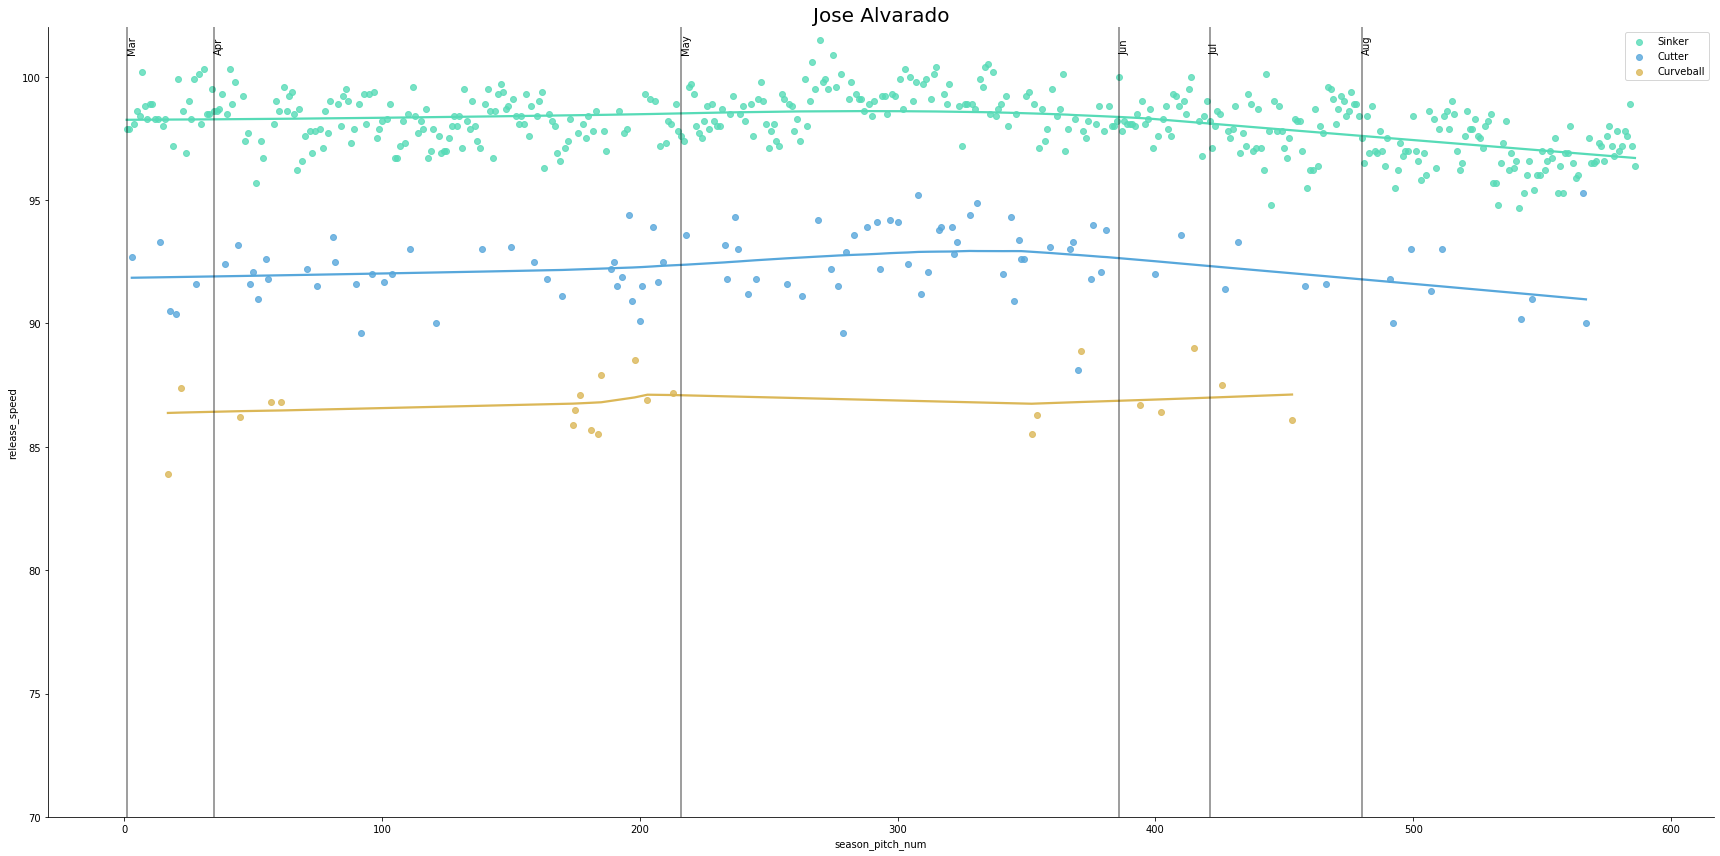

Gathering Player Data


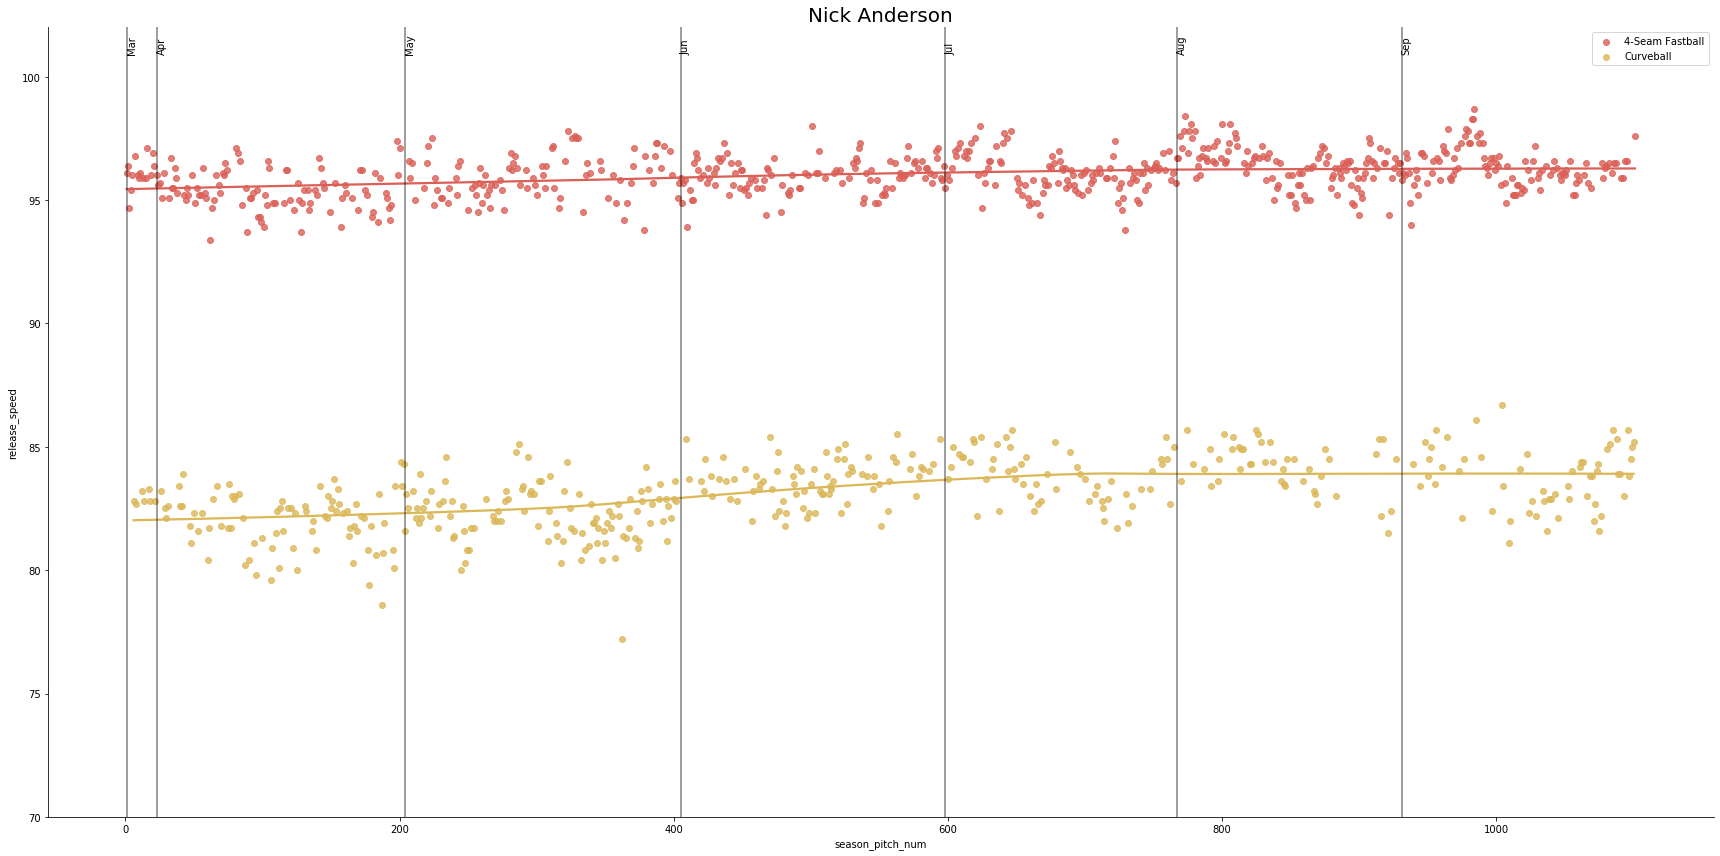

Gathering Player Data


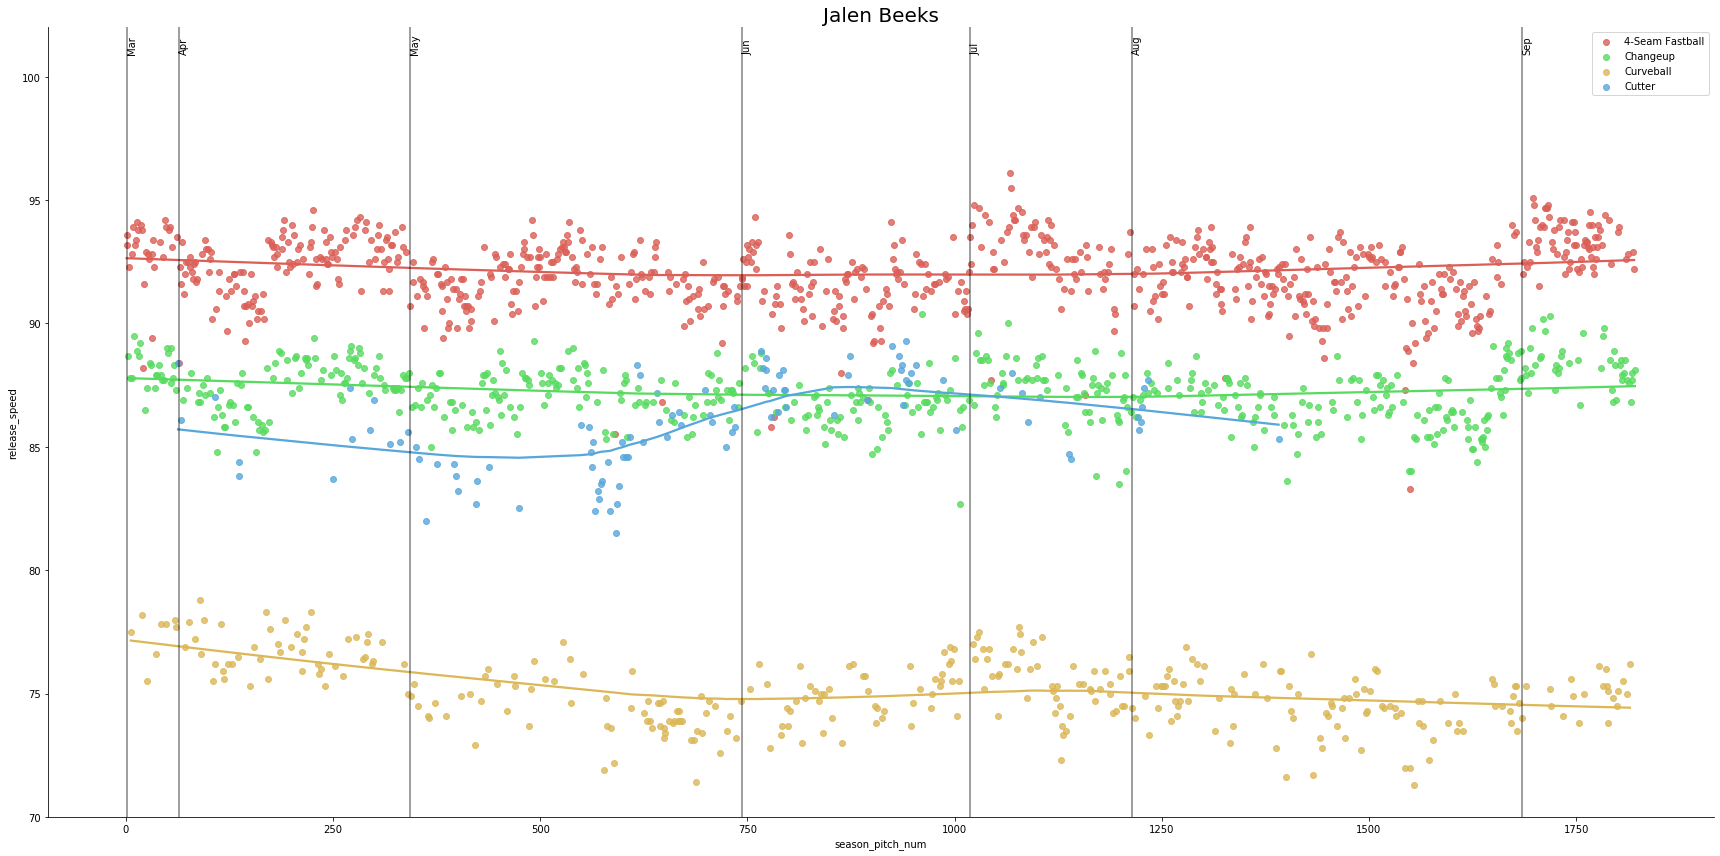

Gathering Player Data


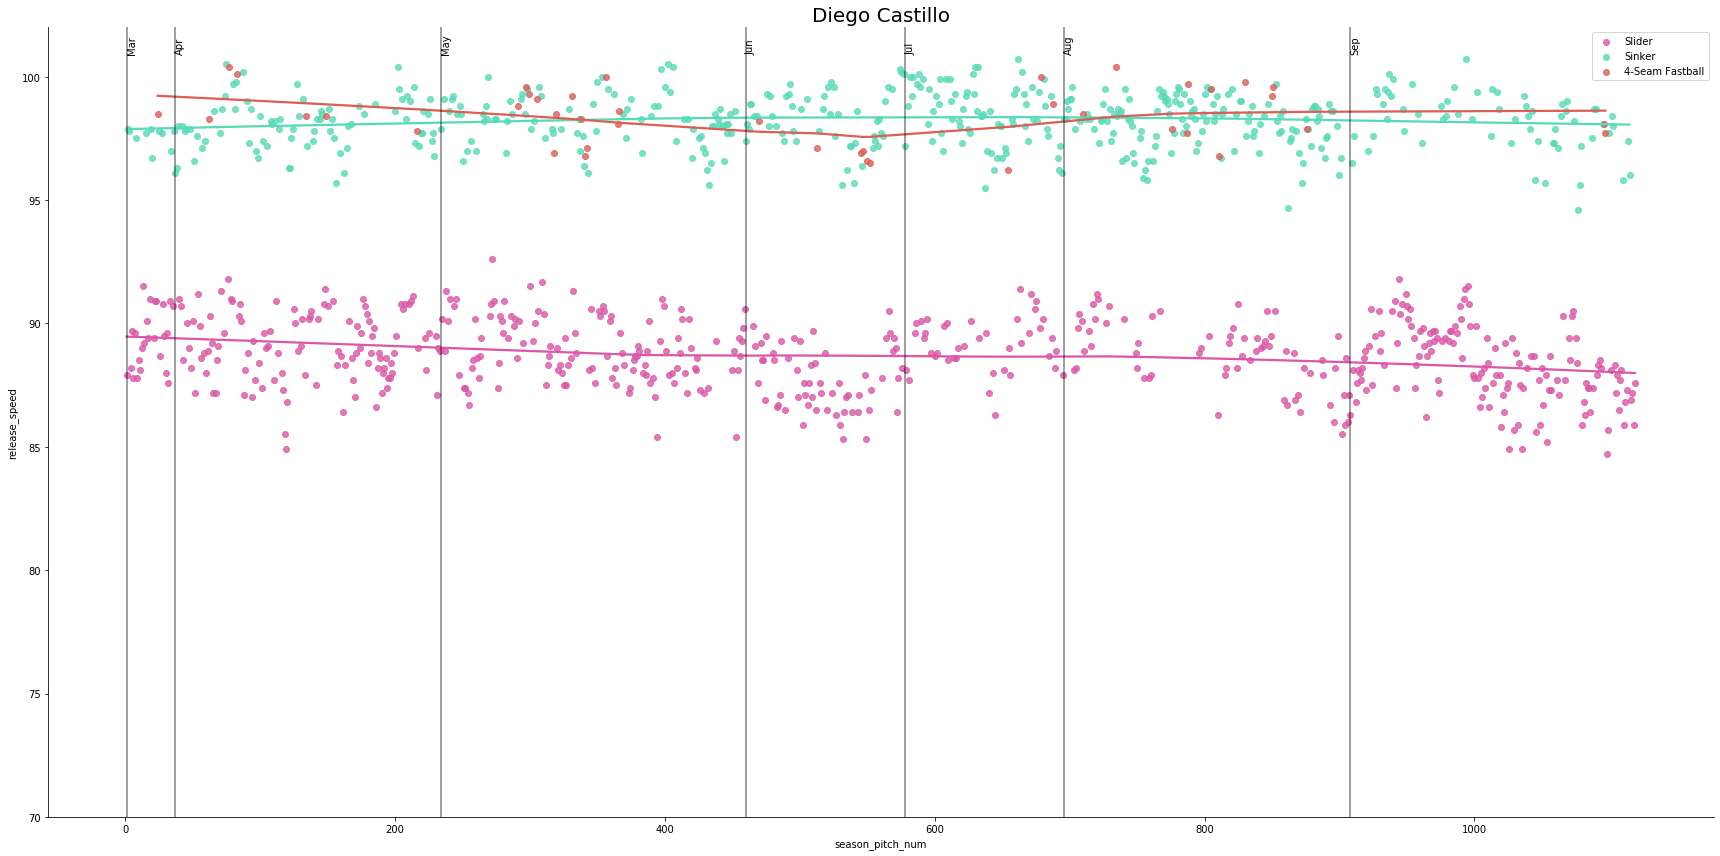

Gathering Player Data


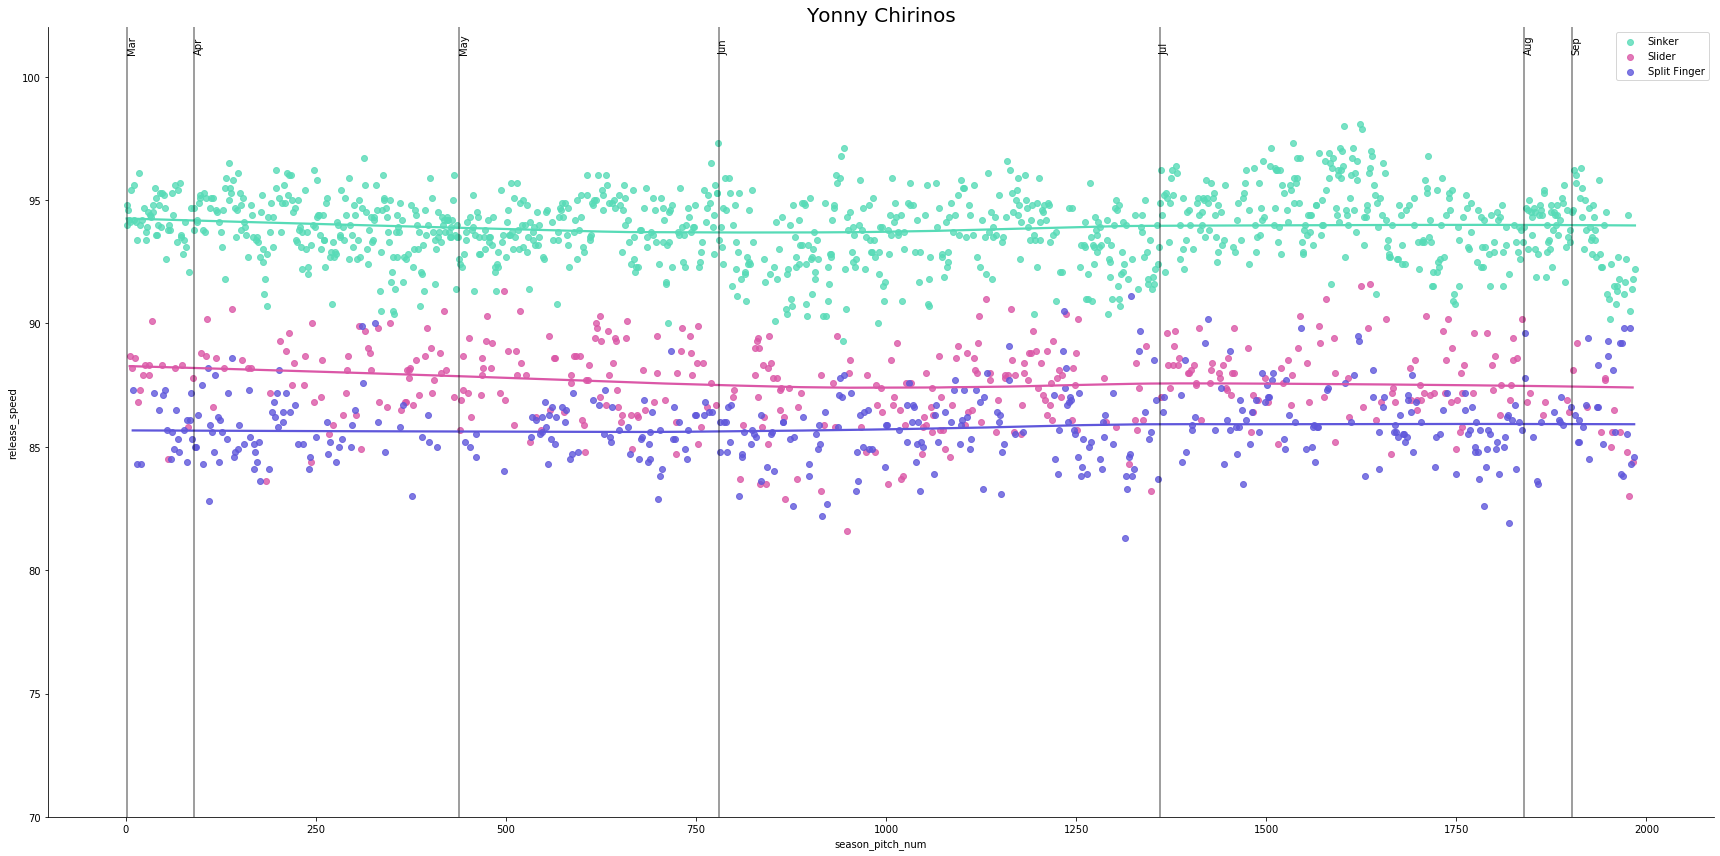

Gathering Player Data


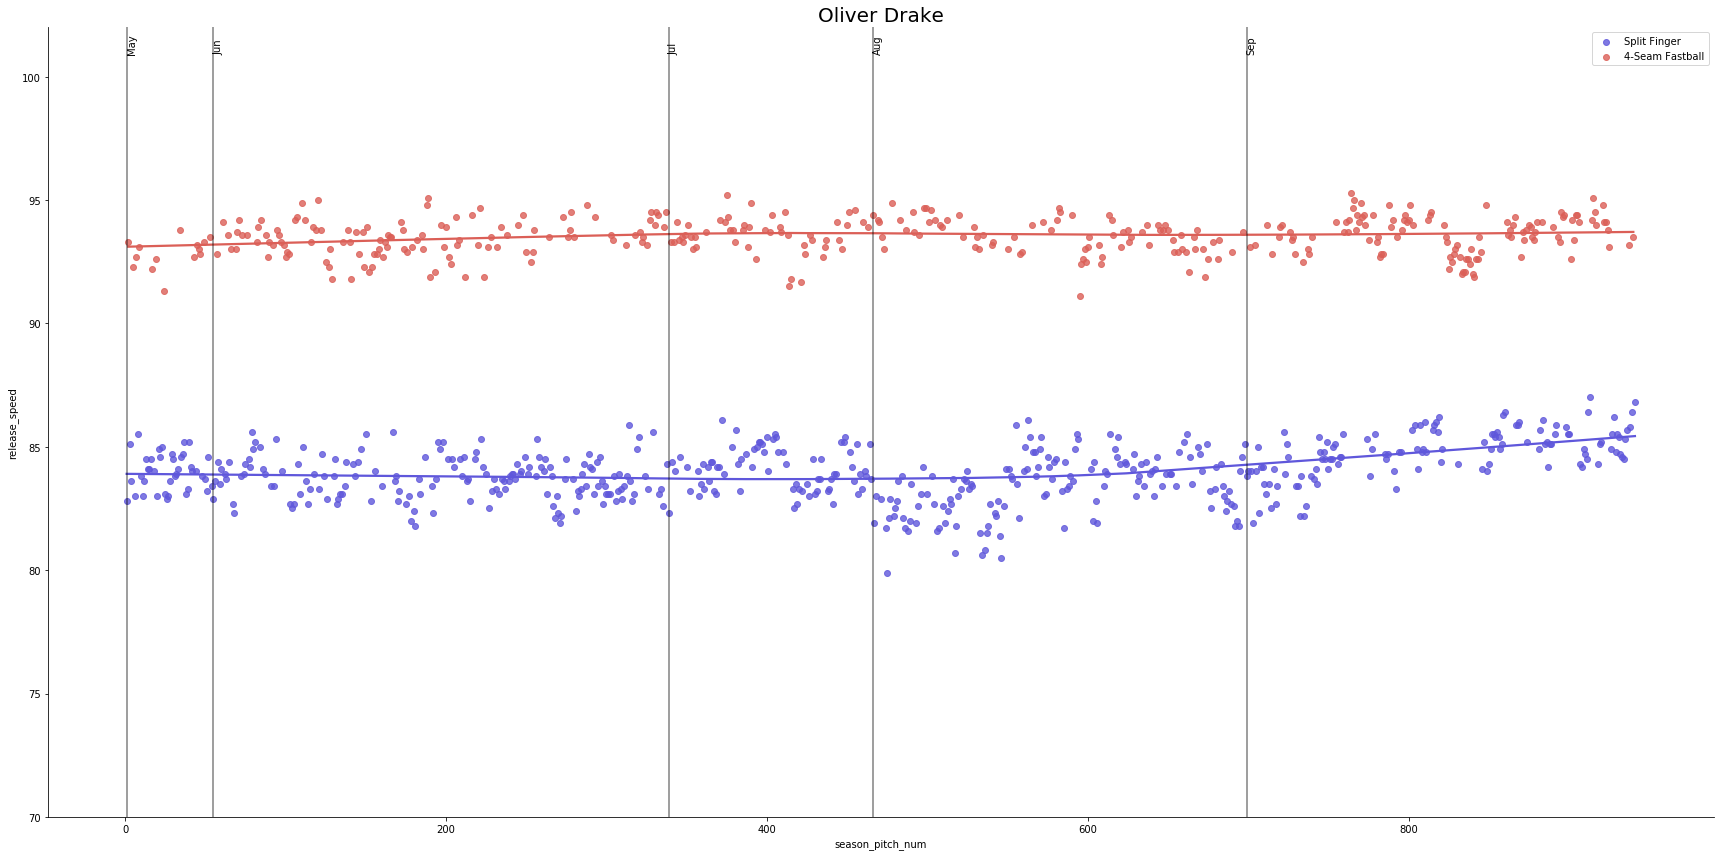

Gathering Player Data


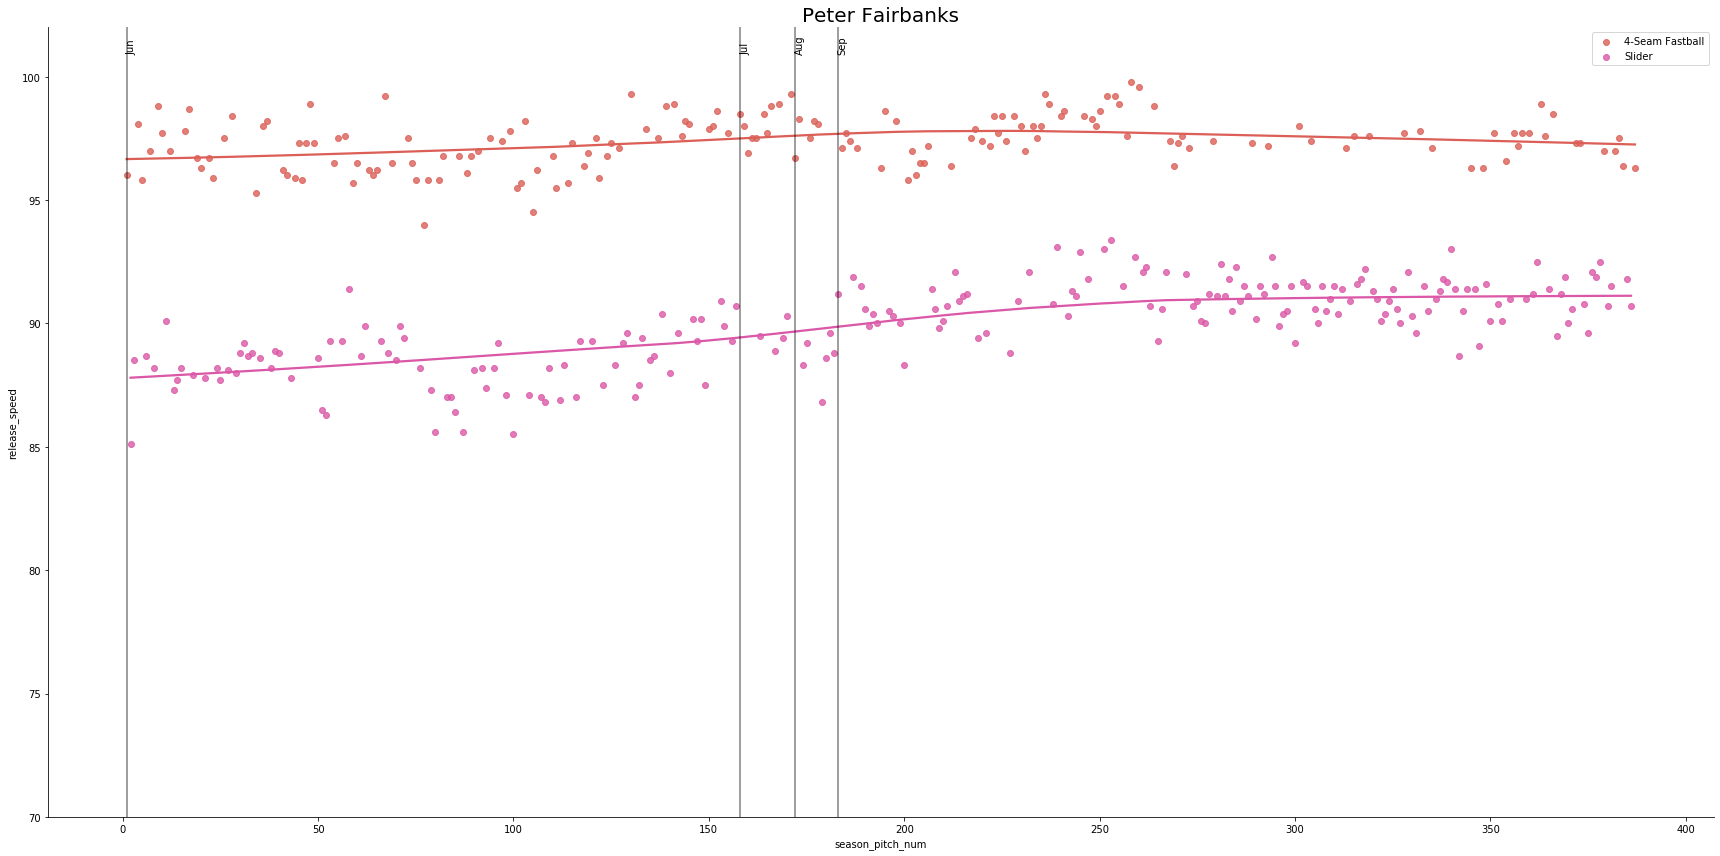

Gathering Player Data


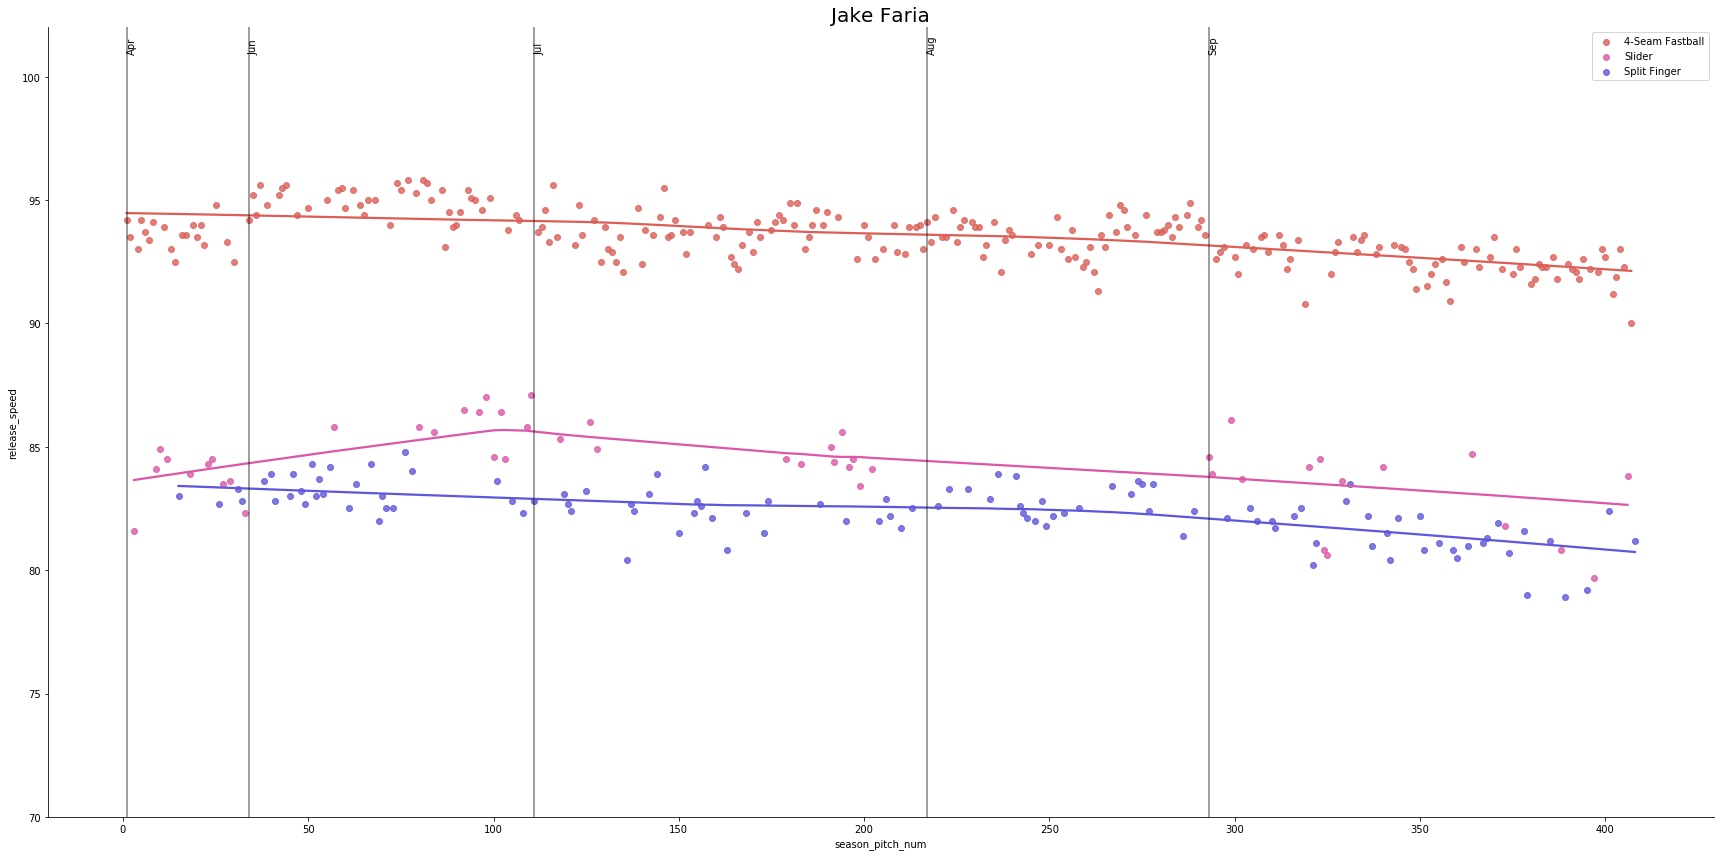

Gathering Player Data


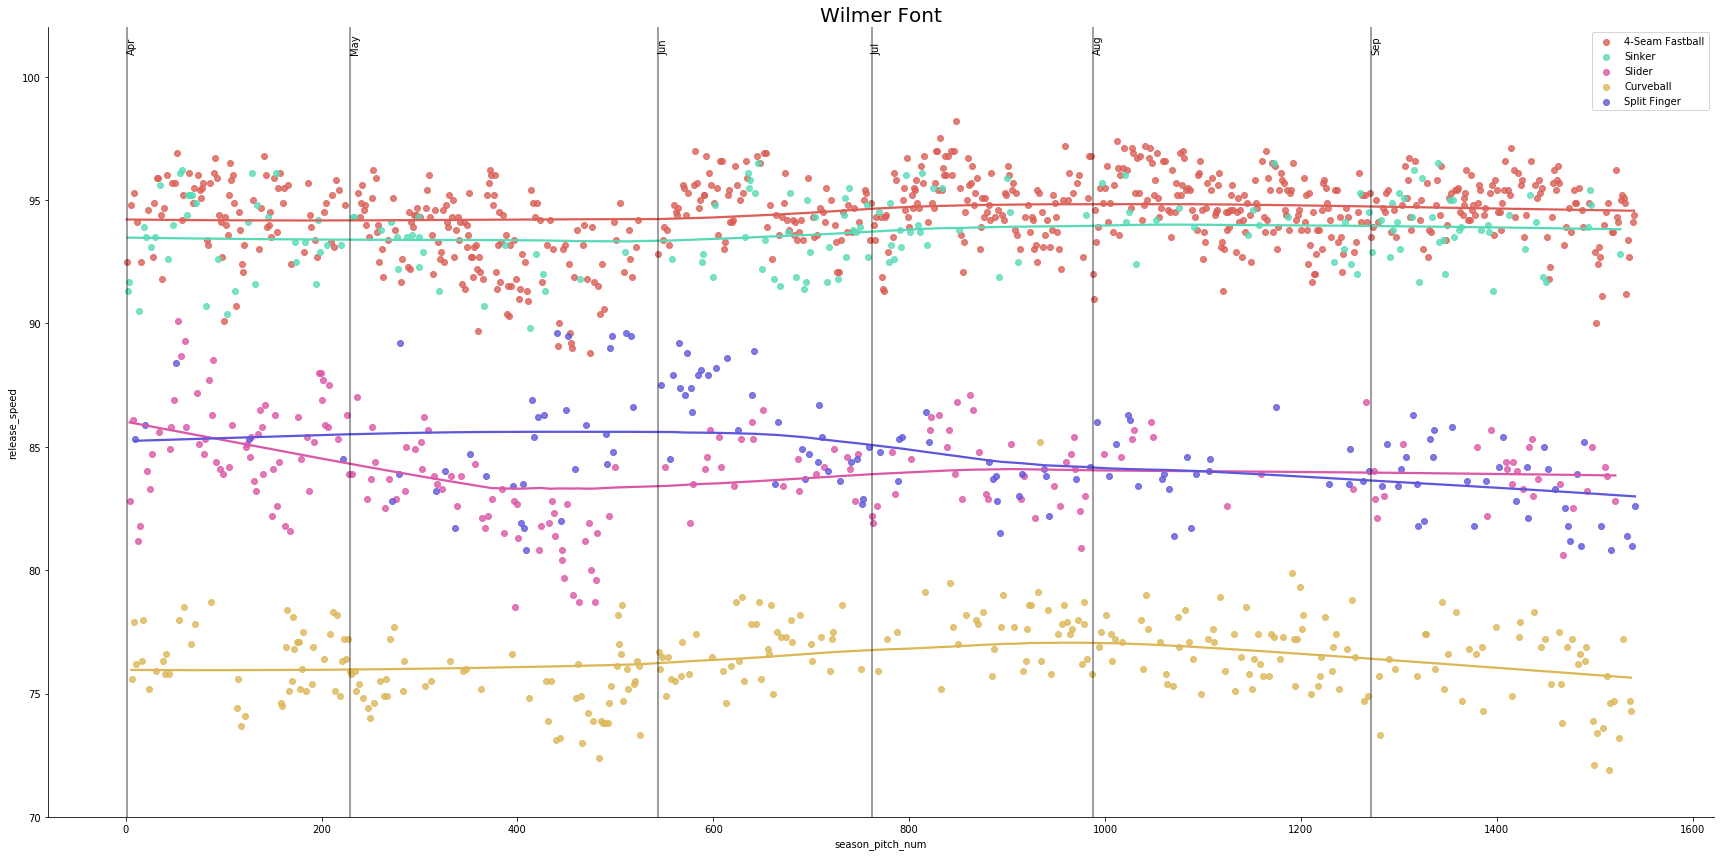

Gathering Player Data


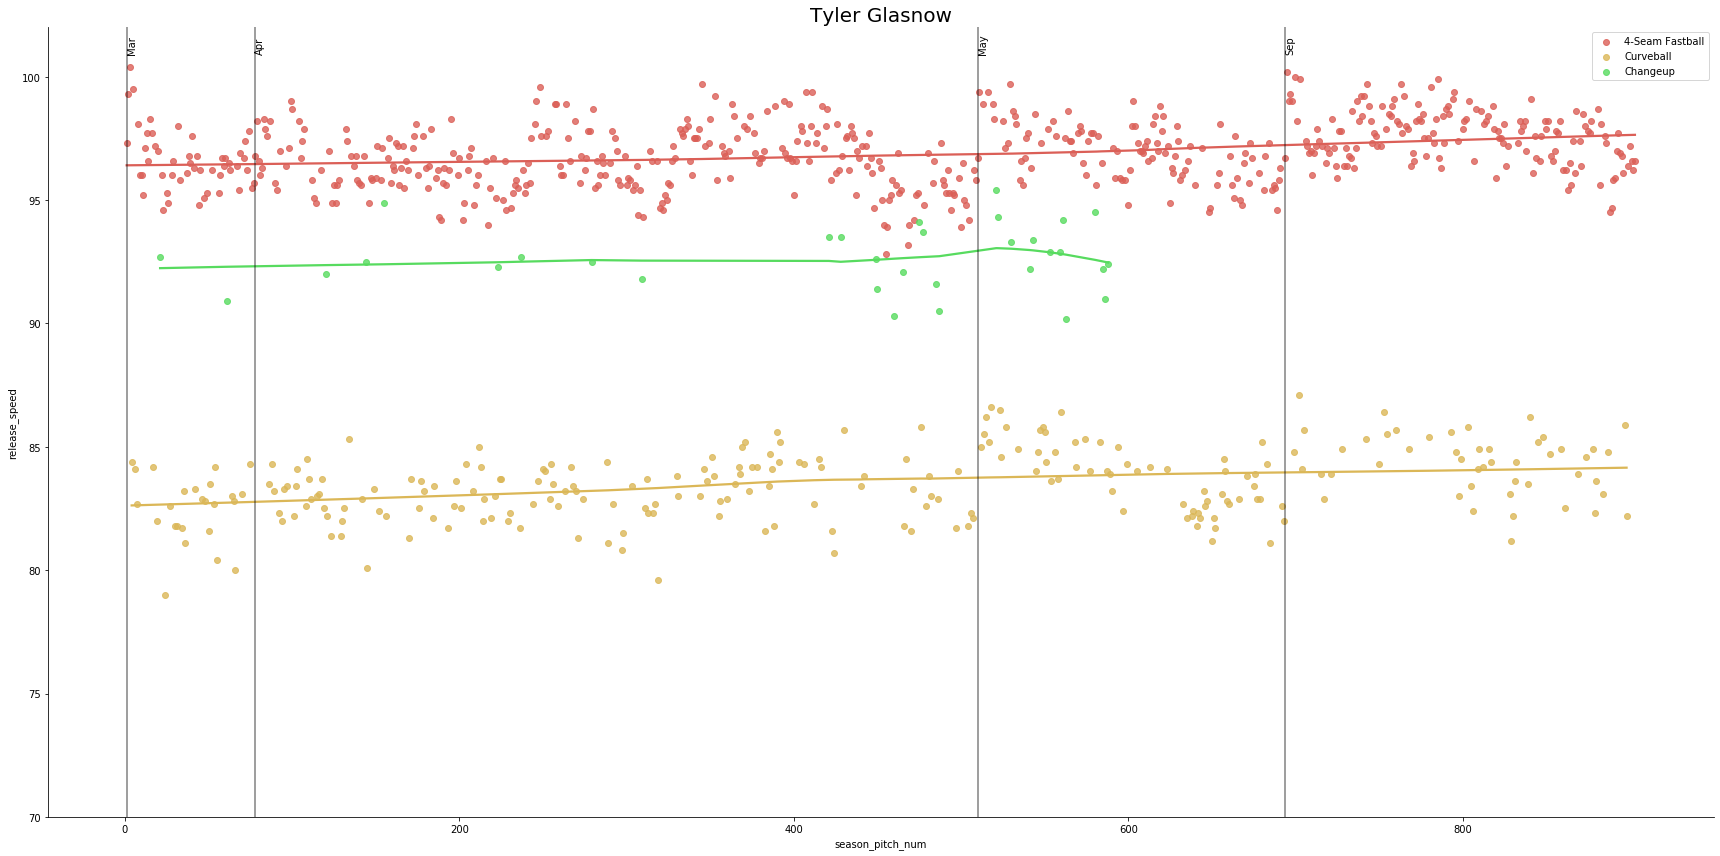

Gathering Player Data


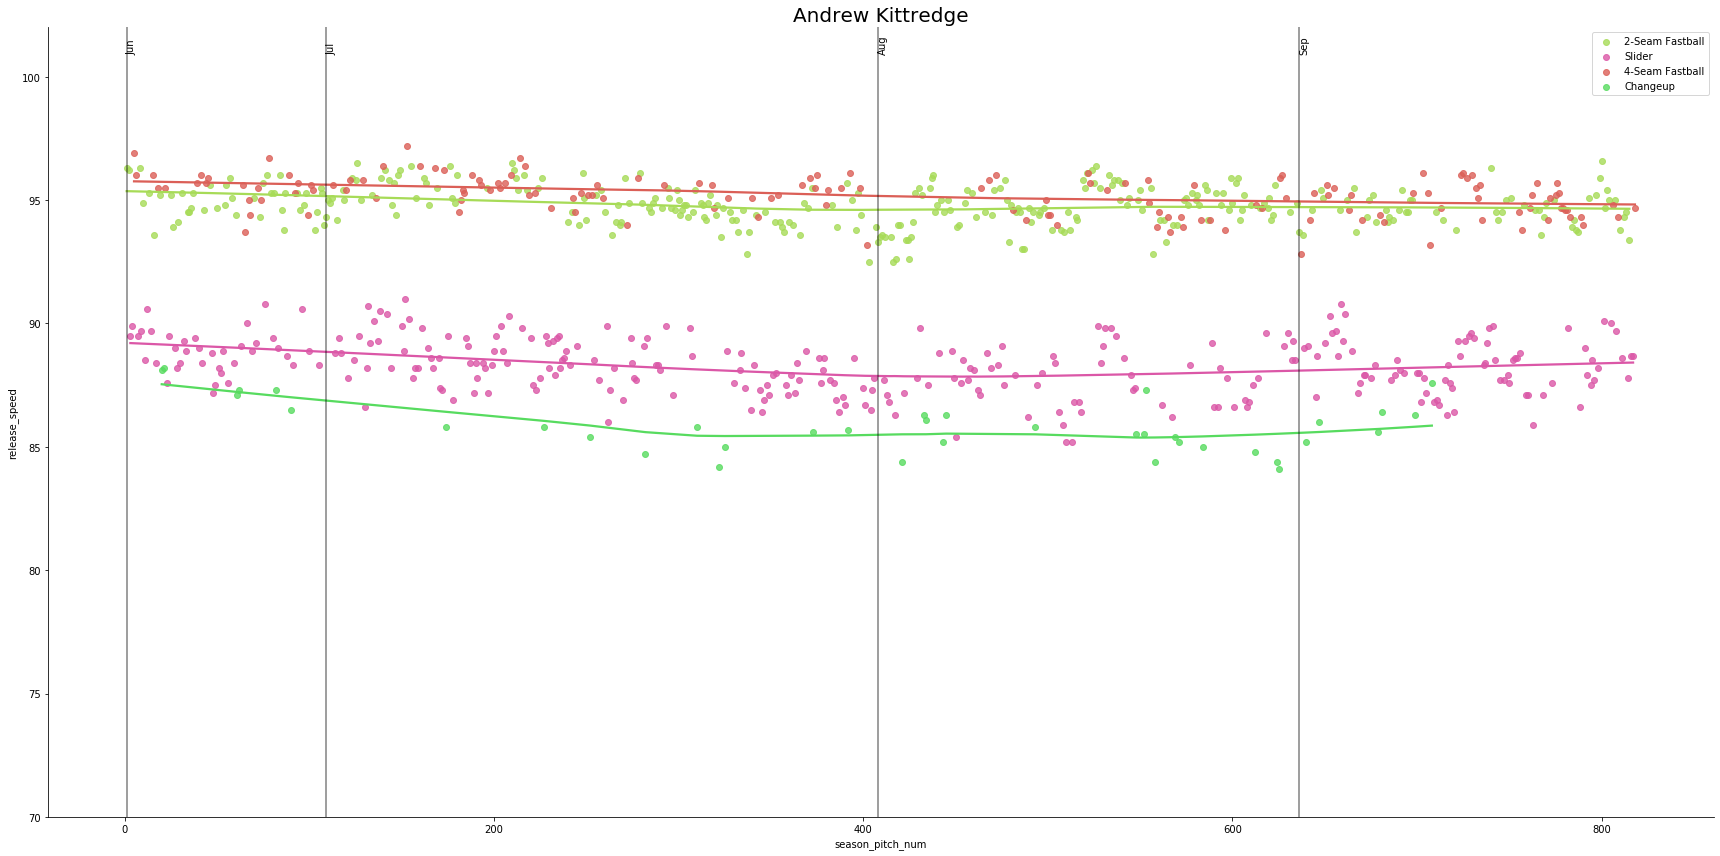

Gathering Player Data


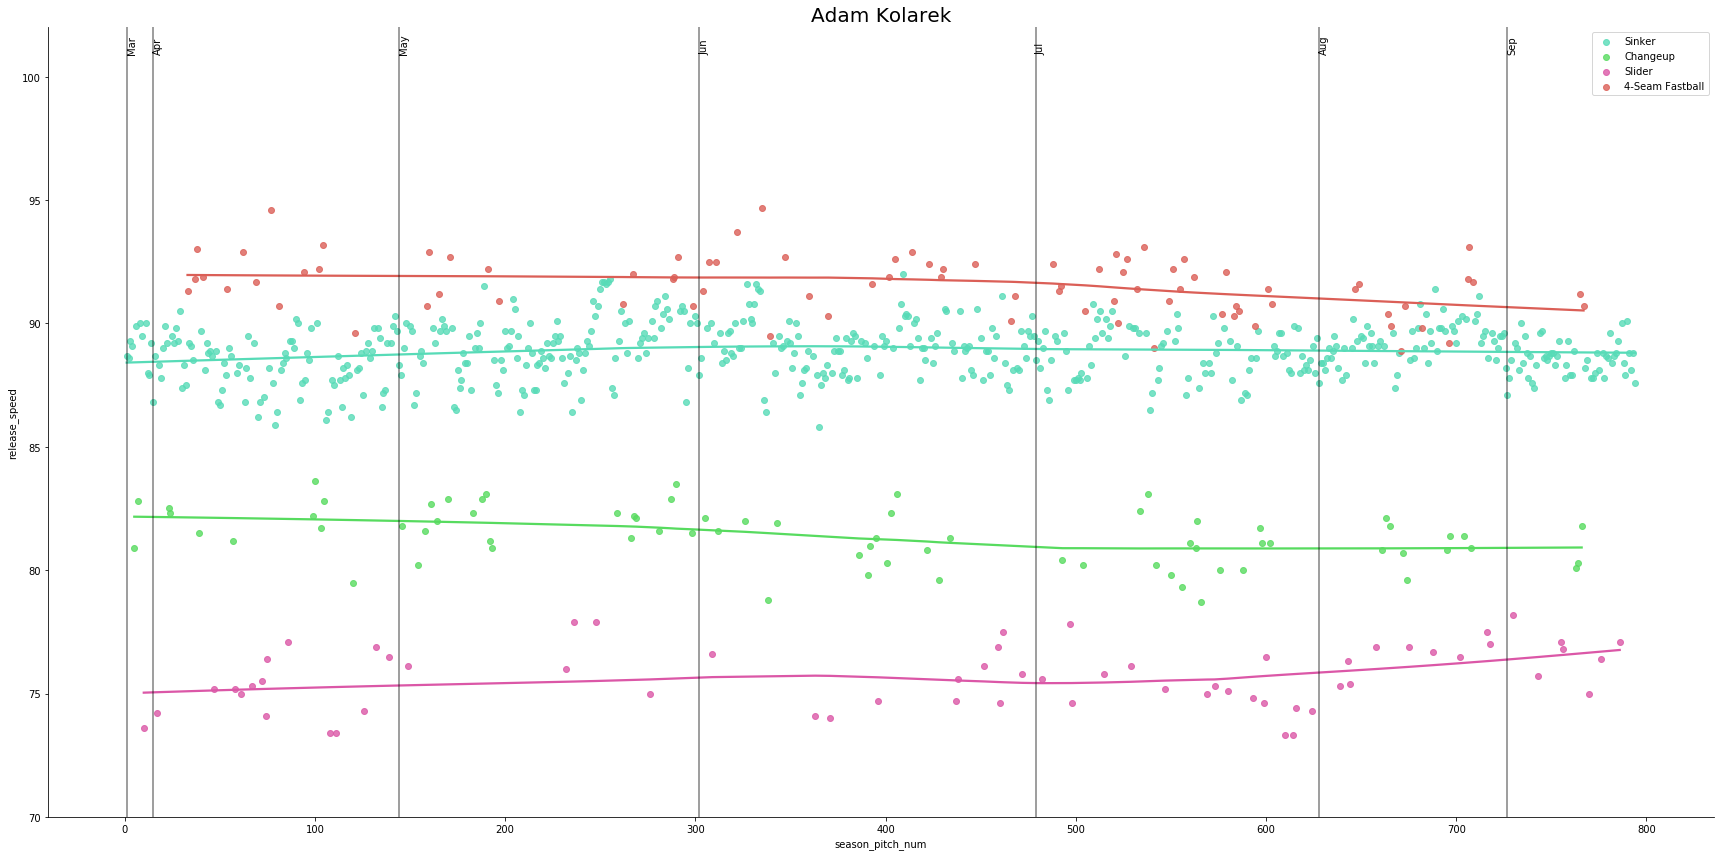

Gathering Player Data


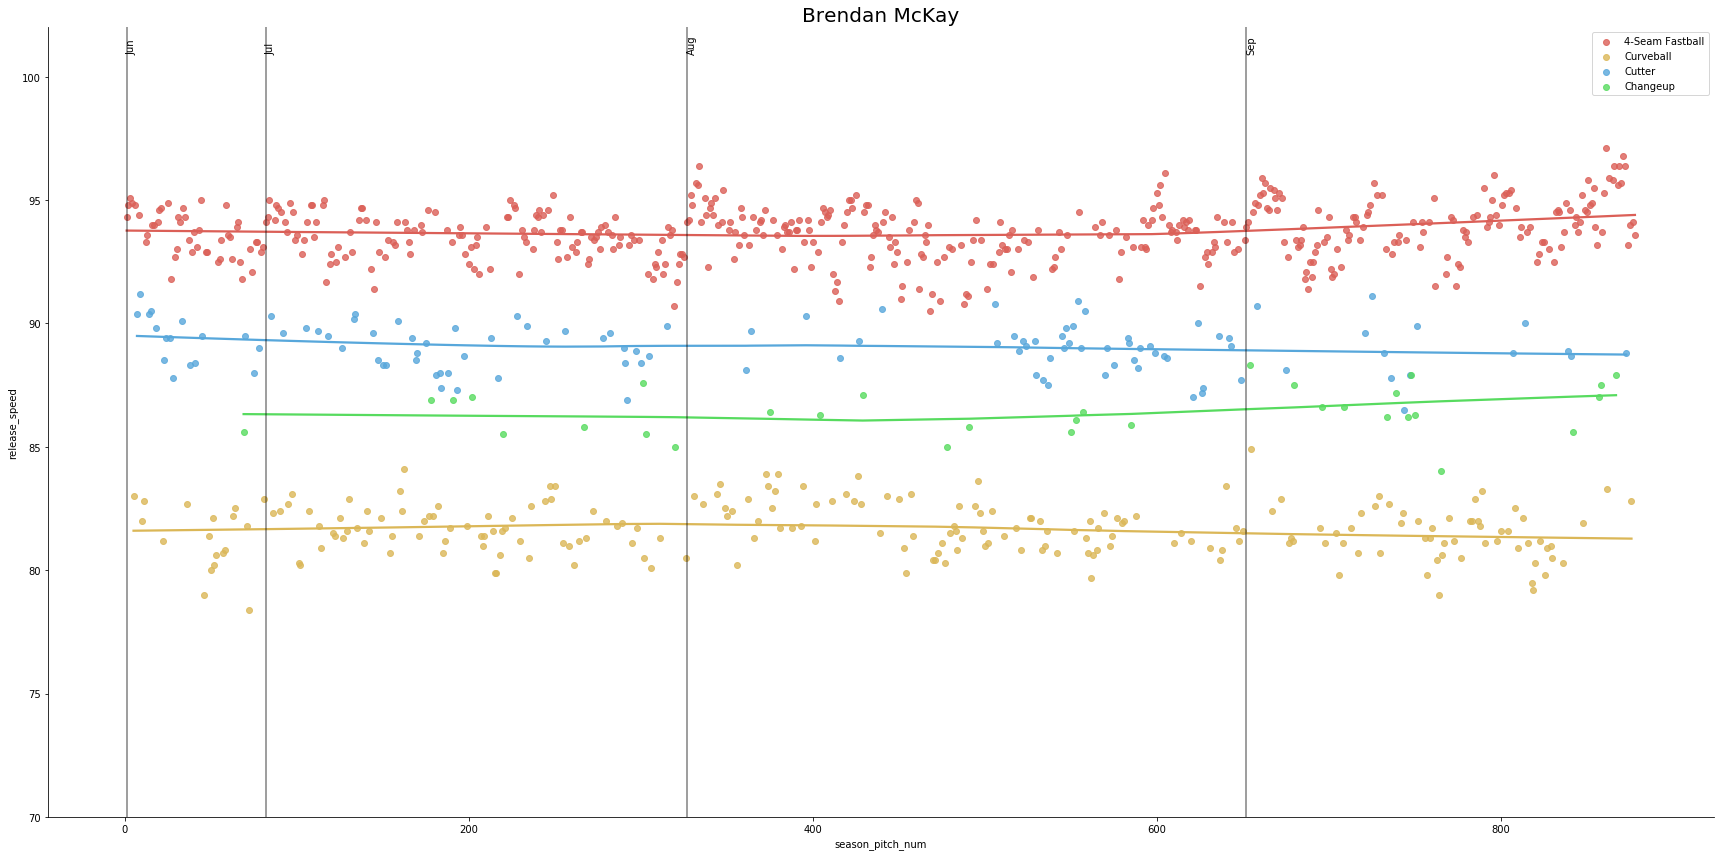

Gathering Player Data


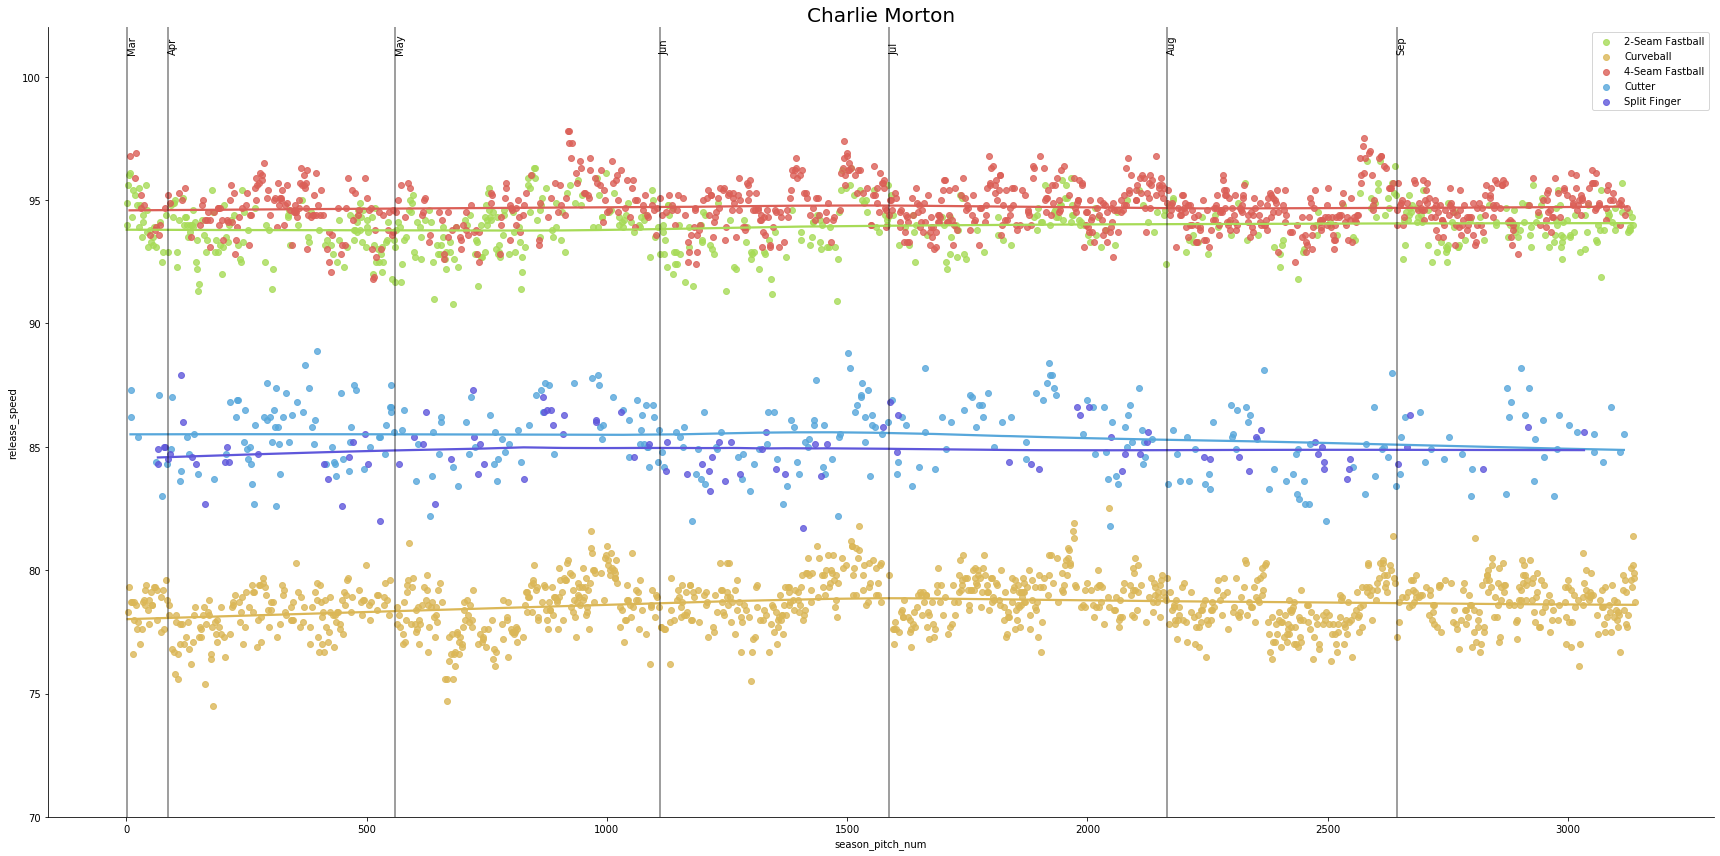

Gathering Player Data


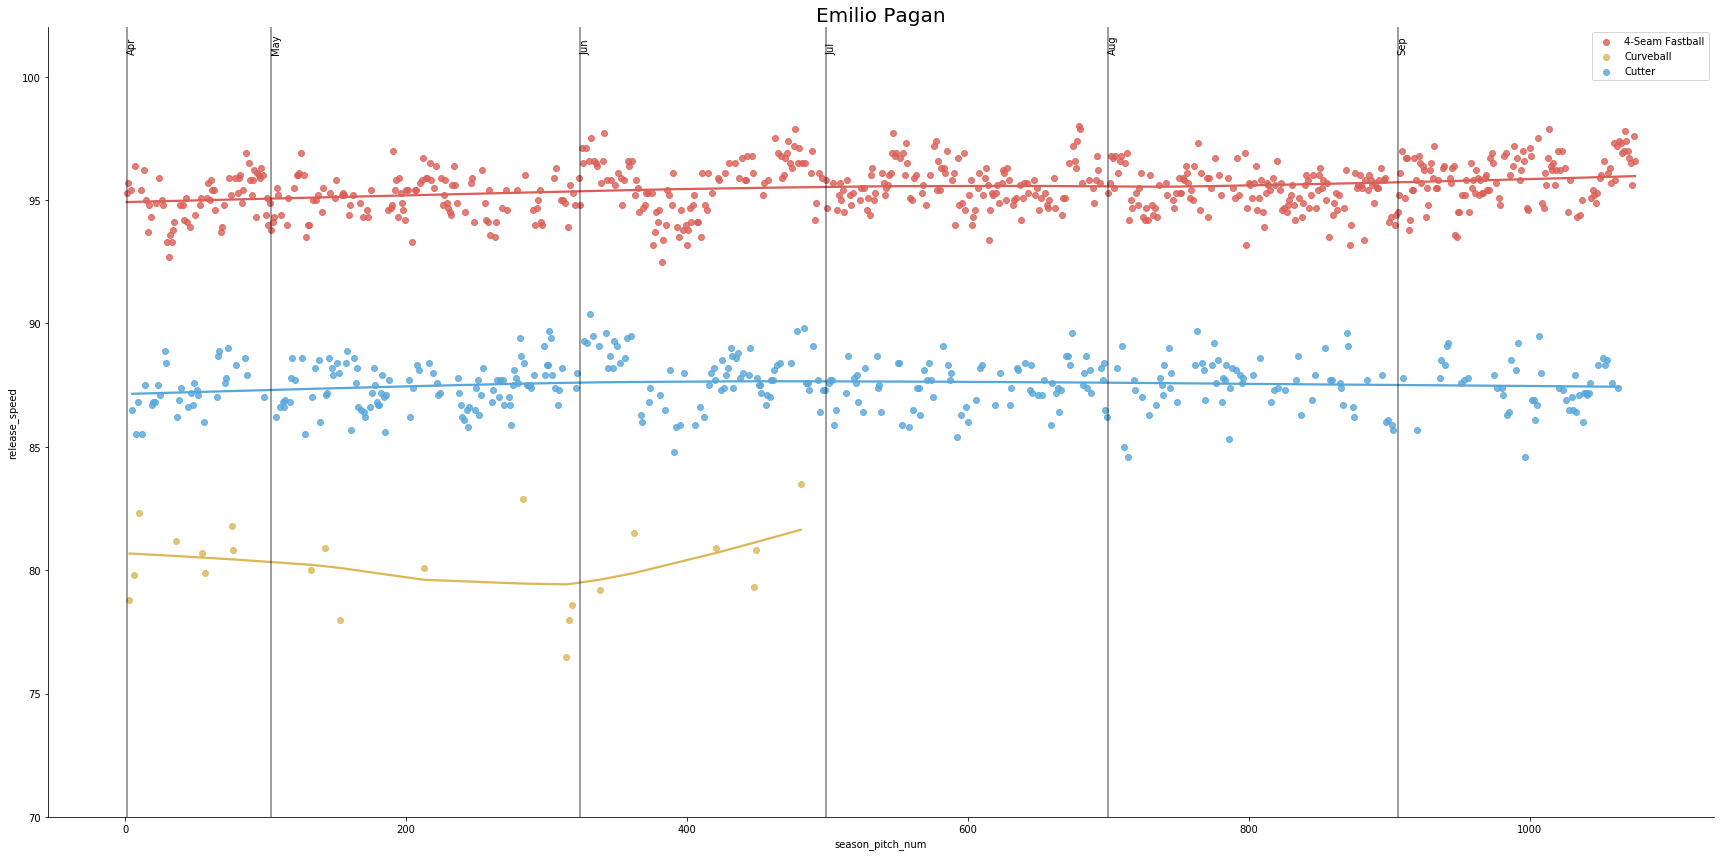

Gathering Player Data


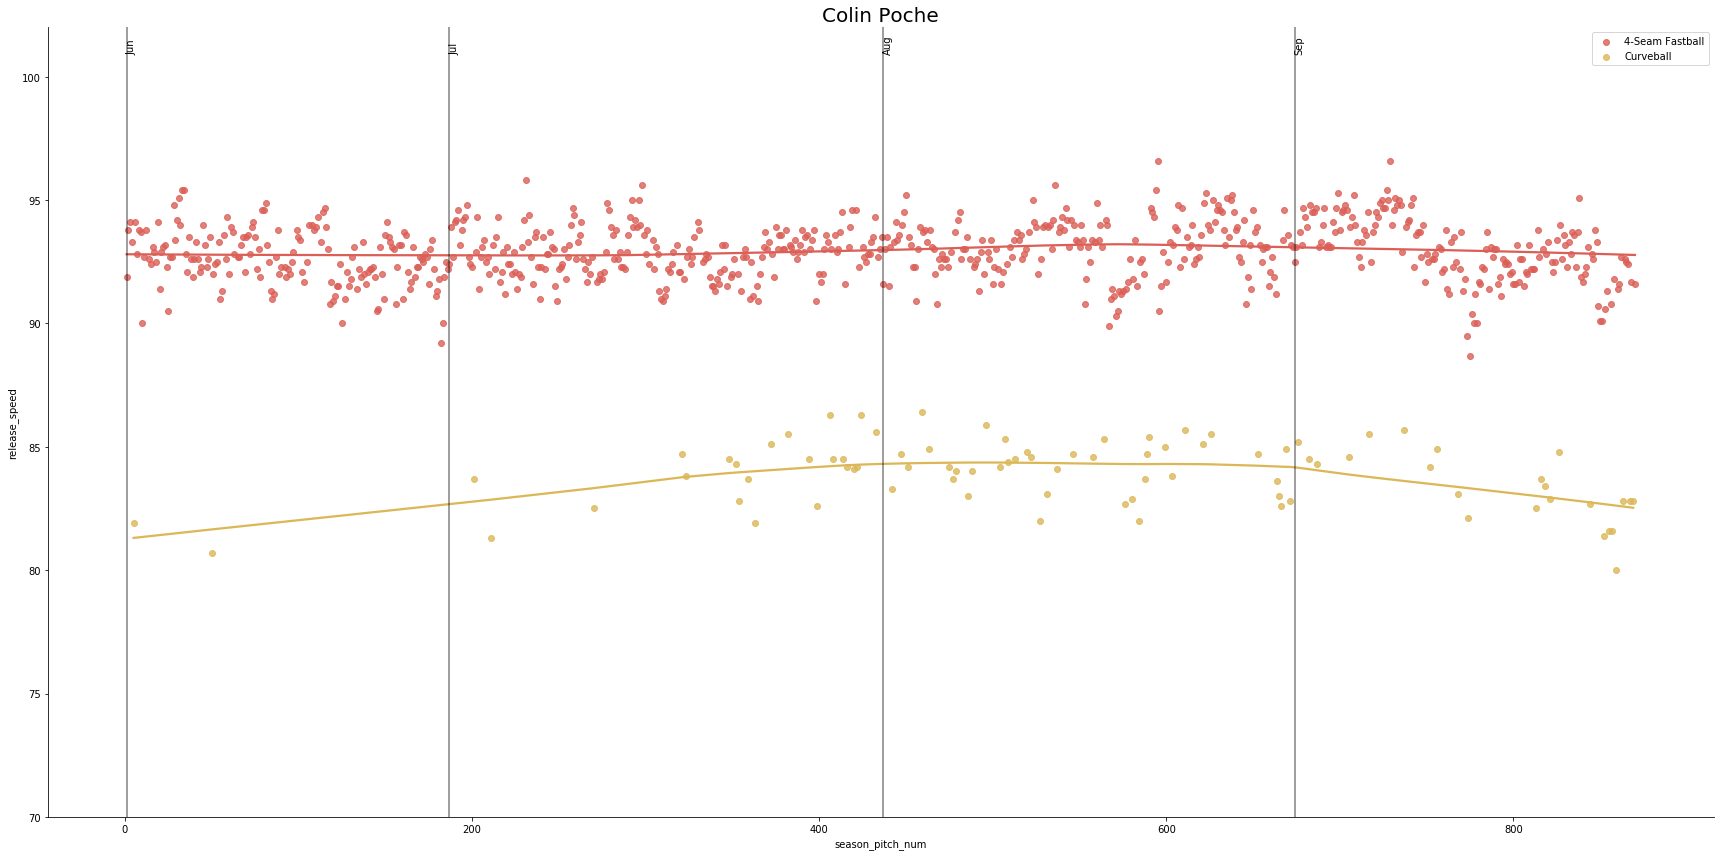

Gathering Player Data


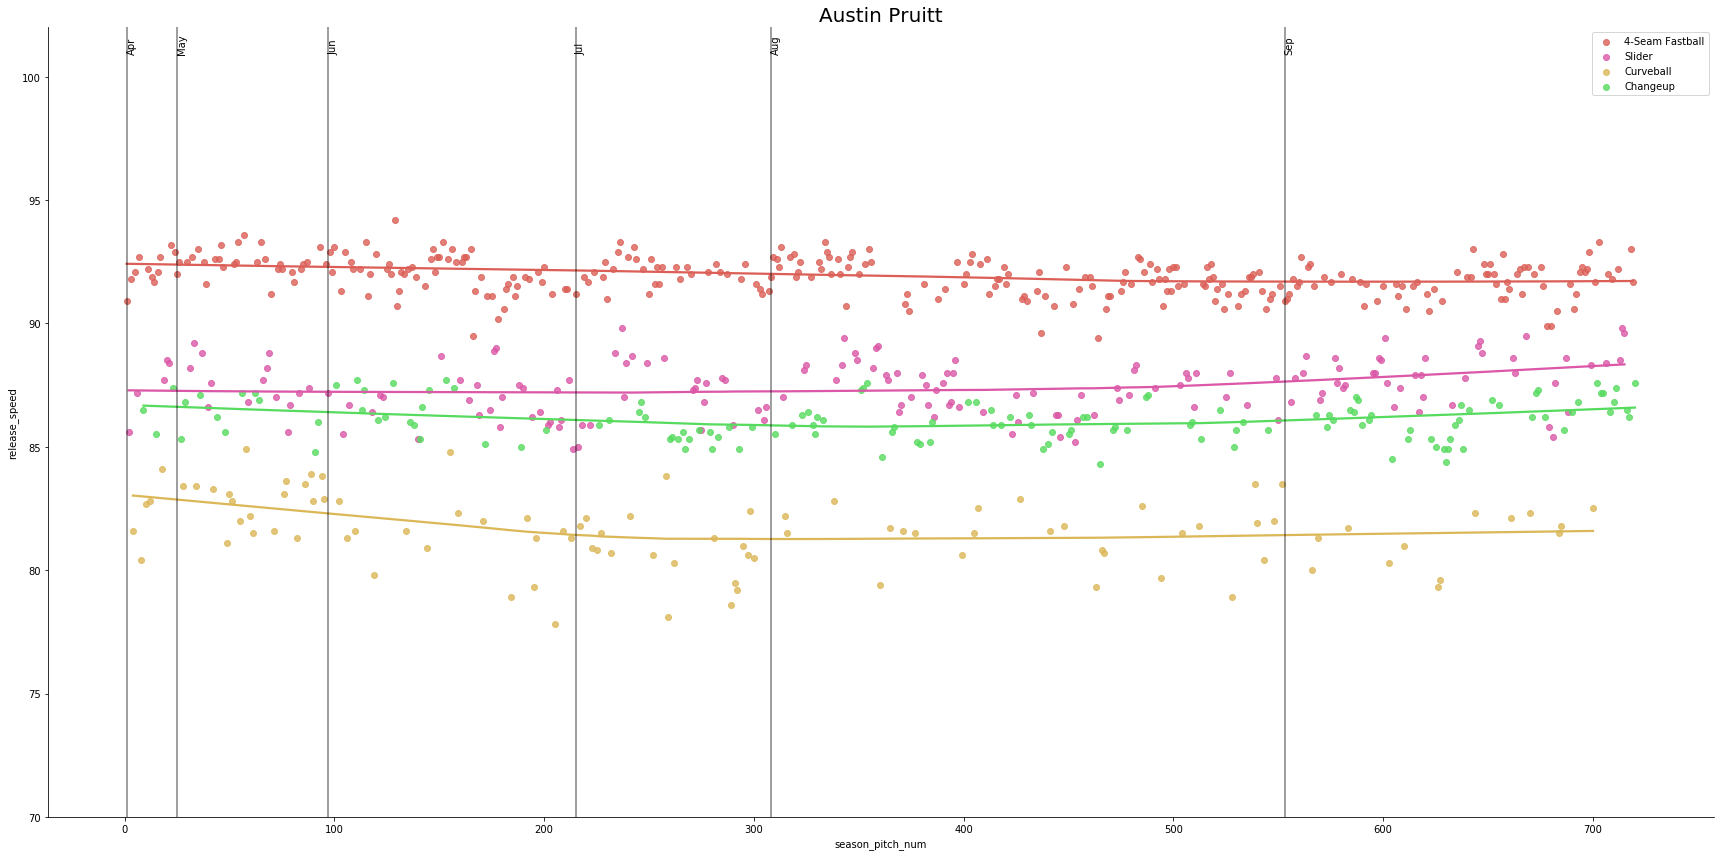

Gathering Player Data


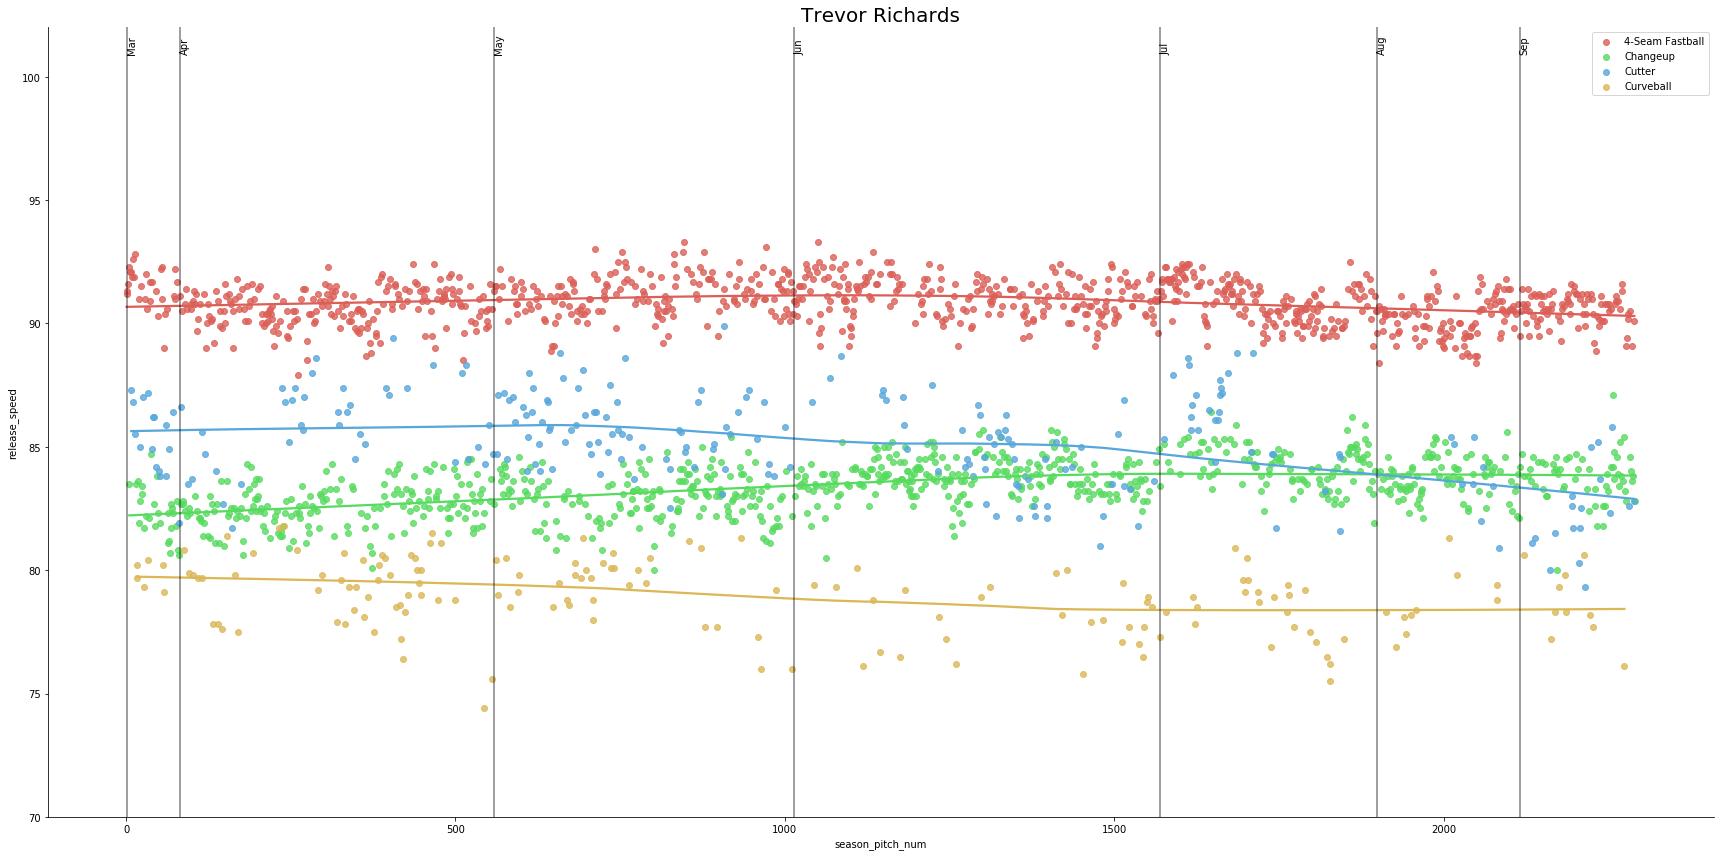

Gathering Player Data


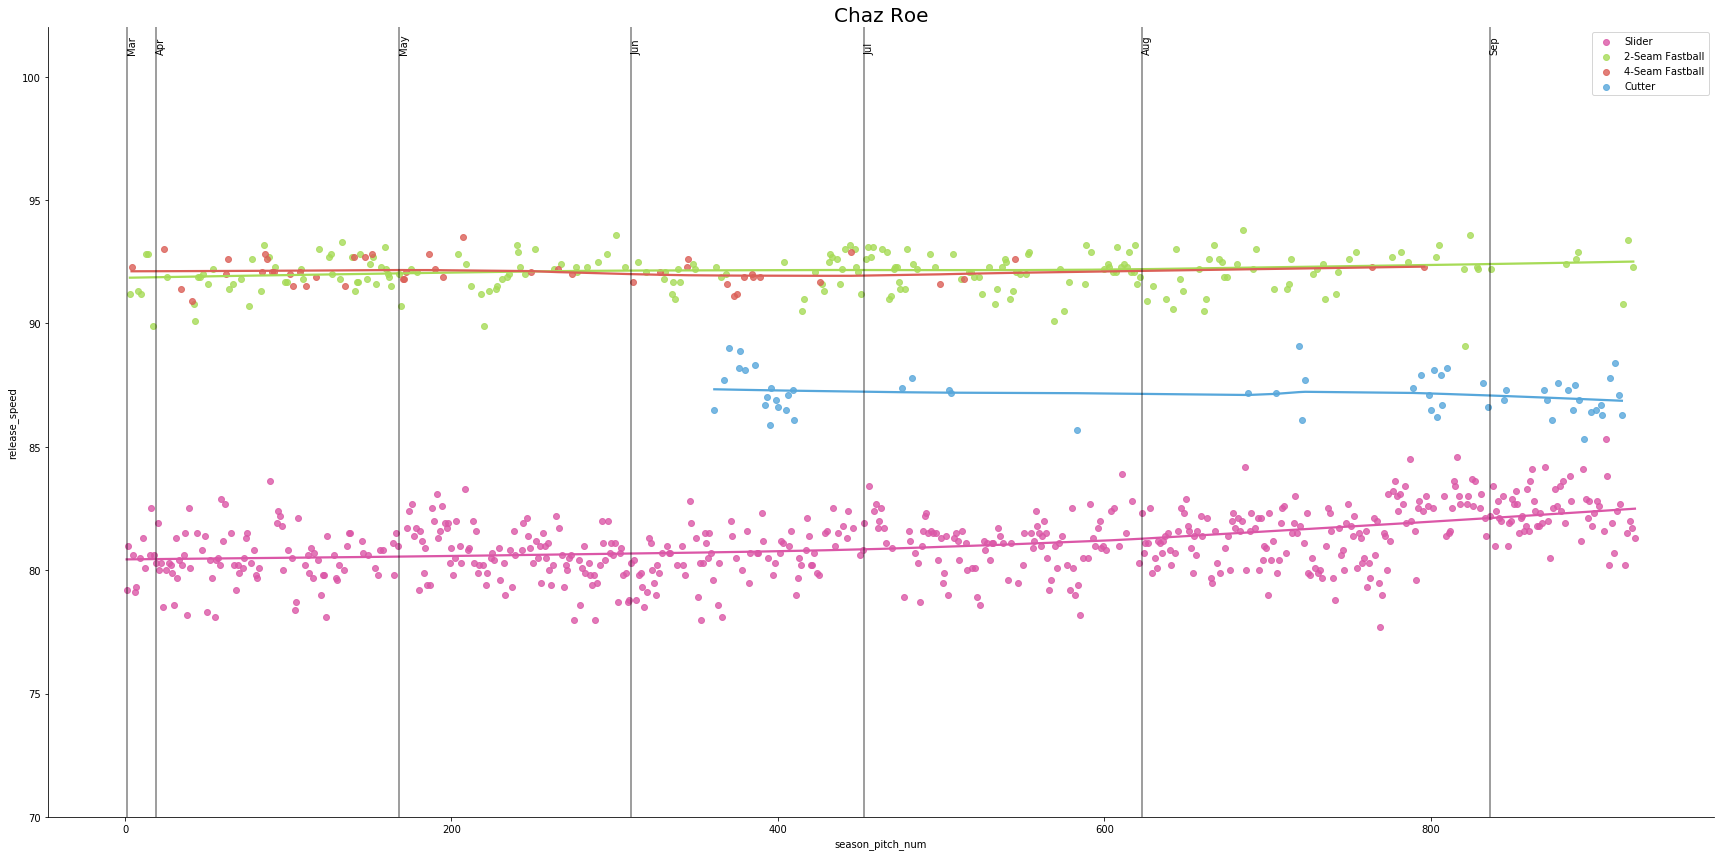

Gathering Player Data


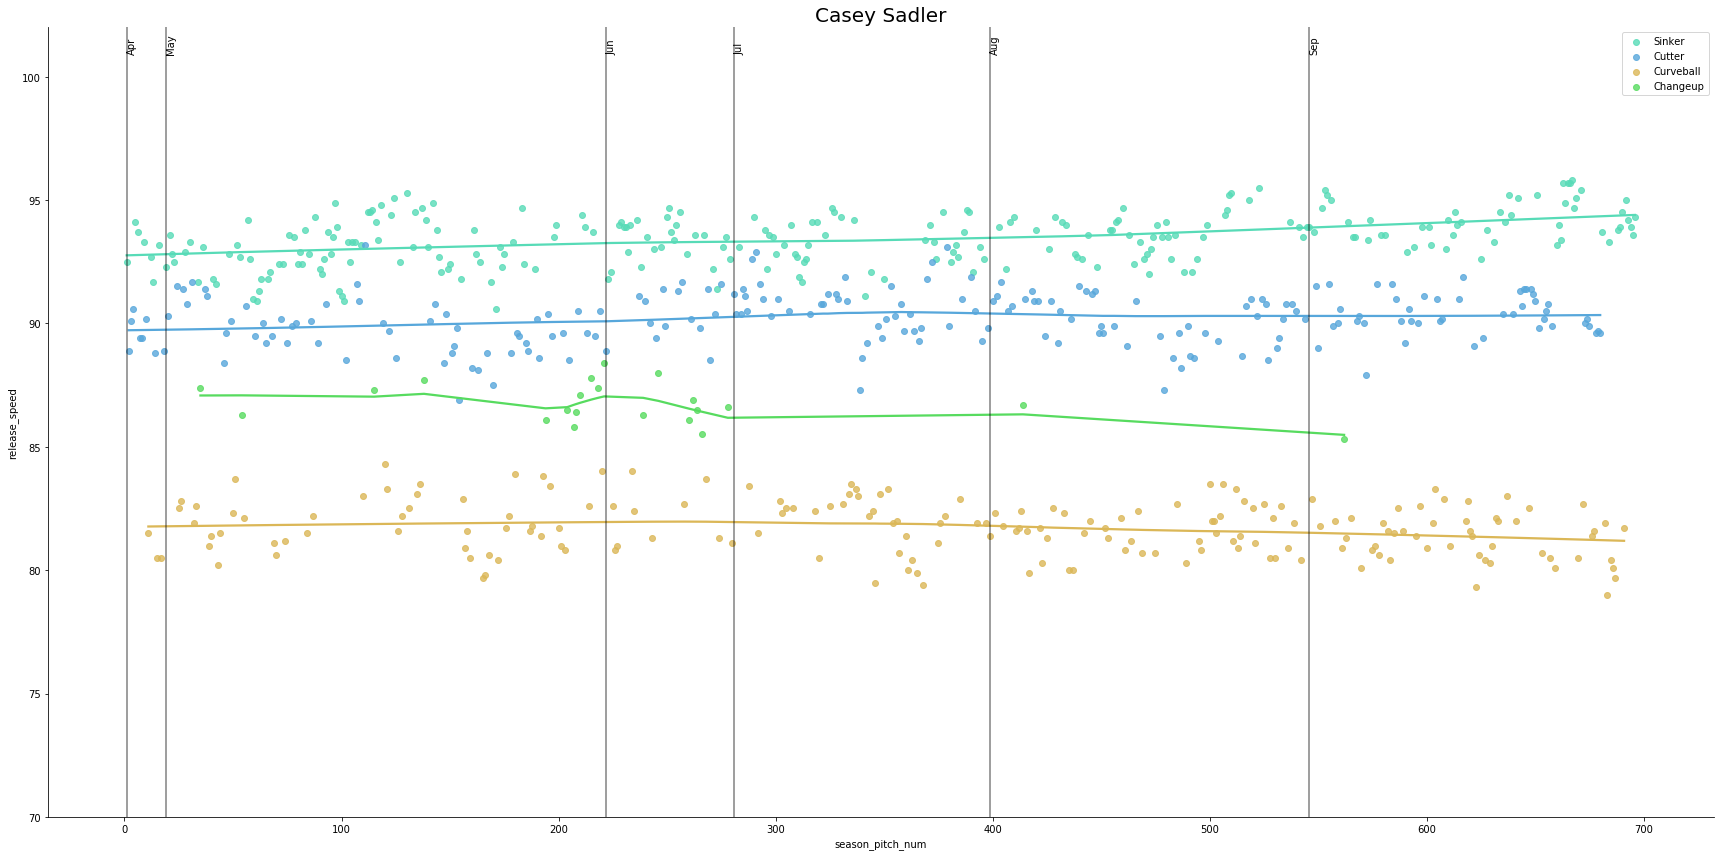

Gathering Player Data


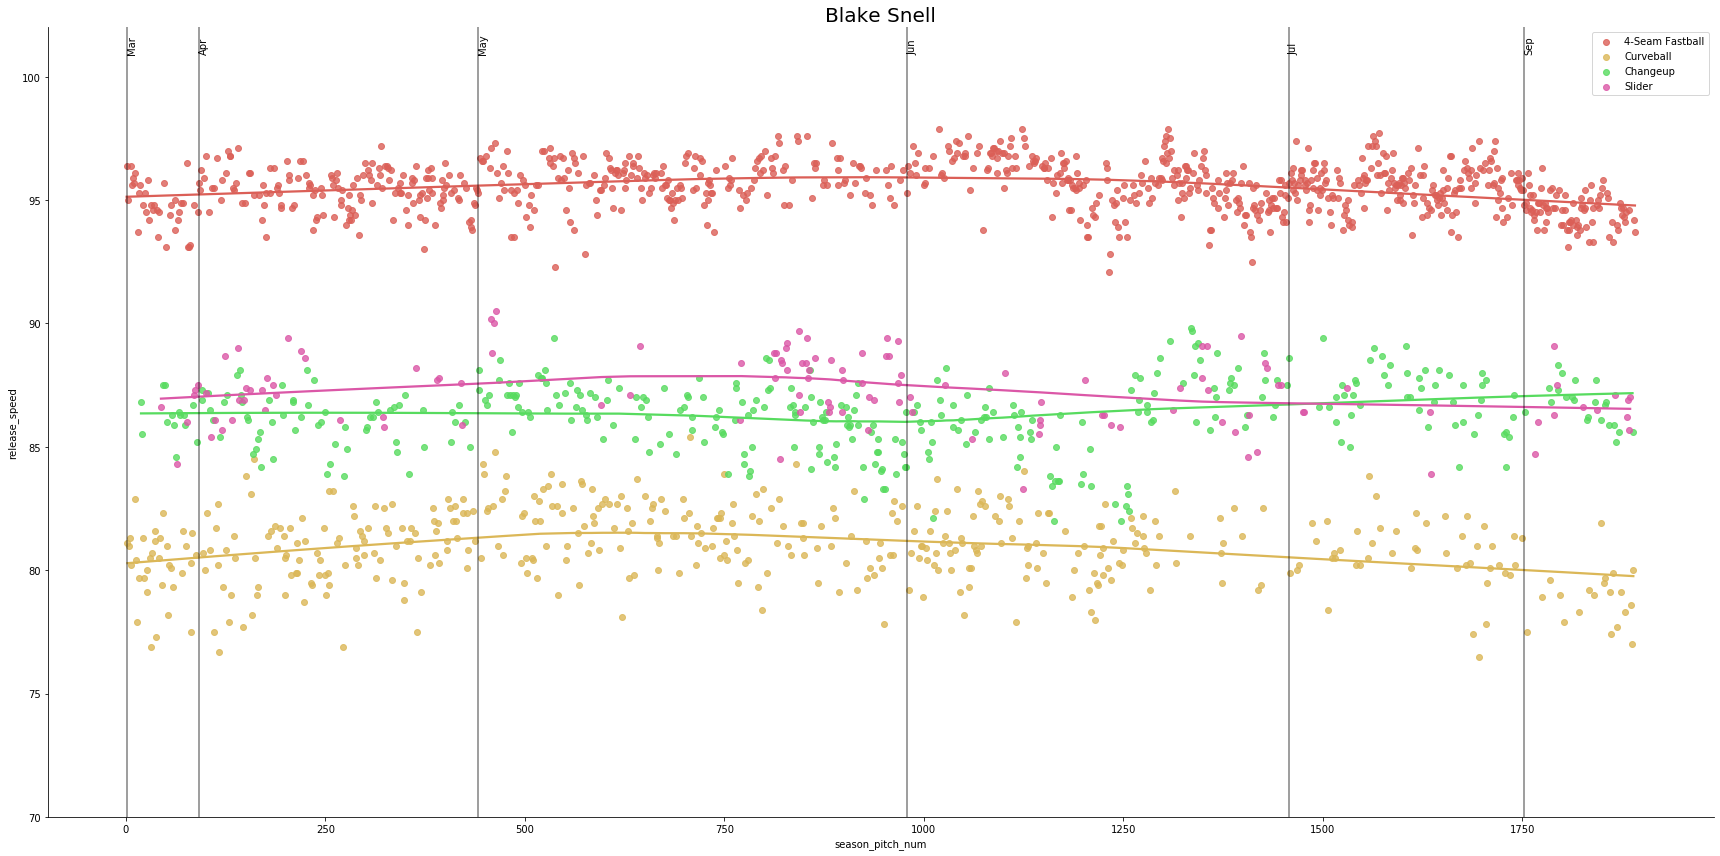

Gathering Player Data


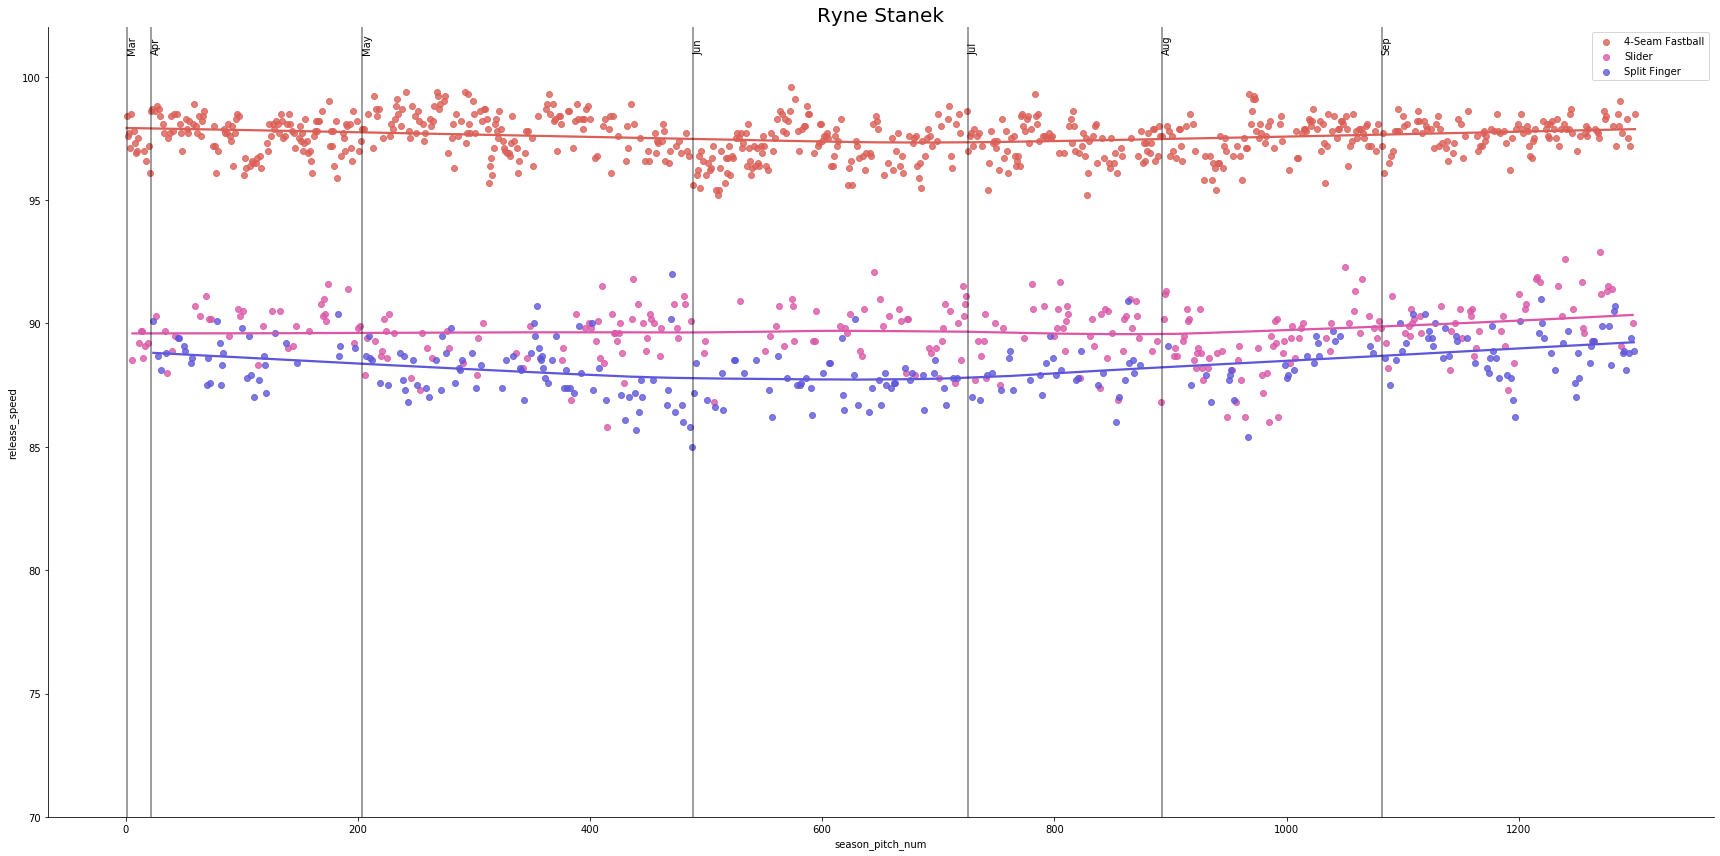

Gathering Player Data


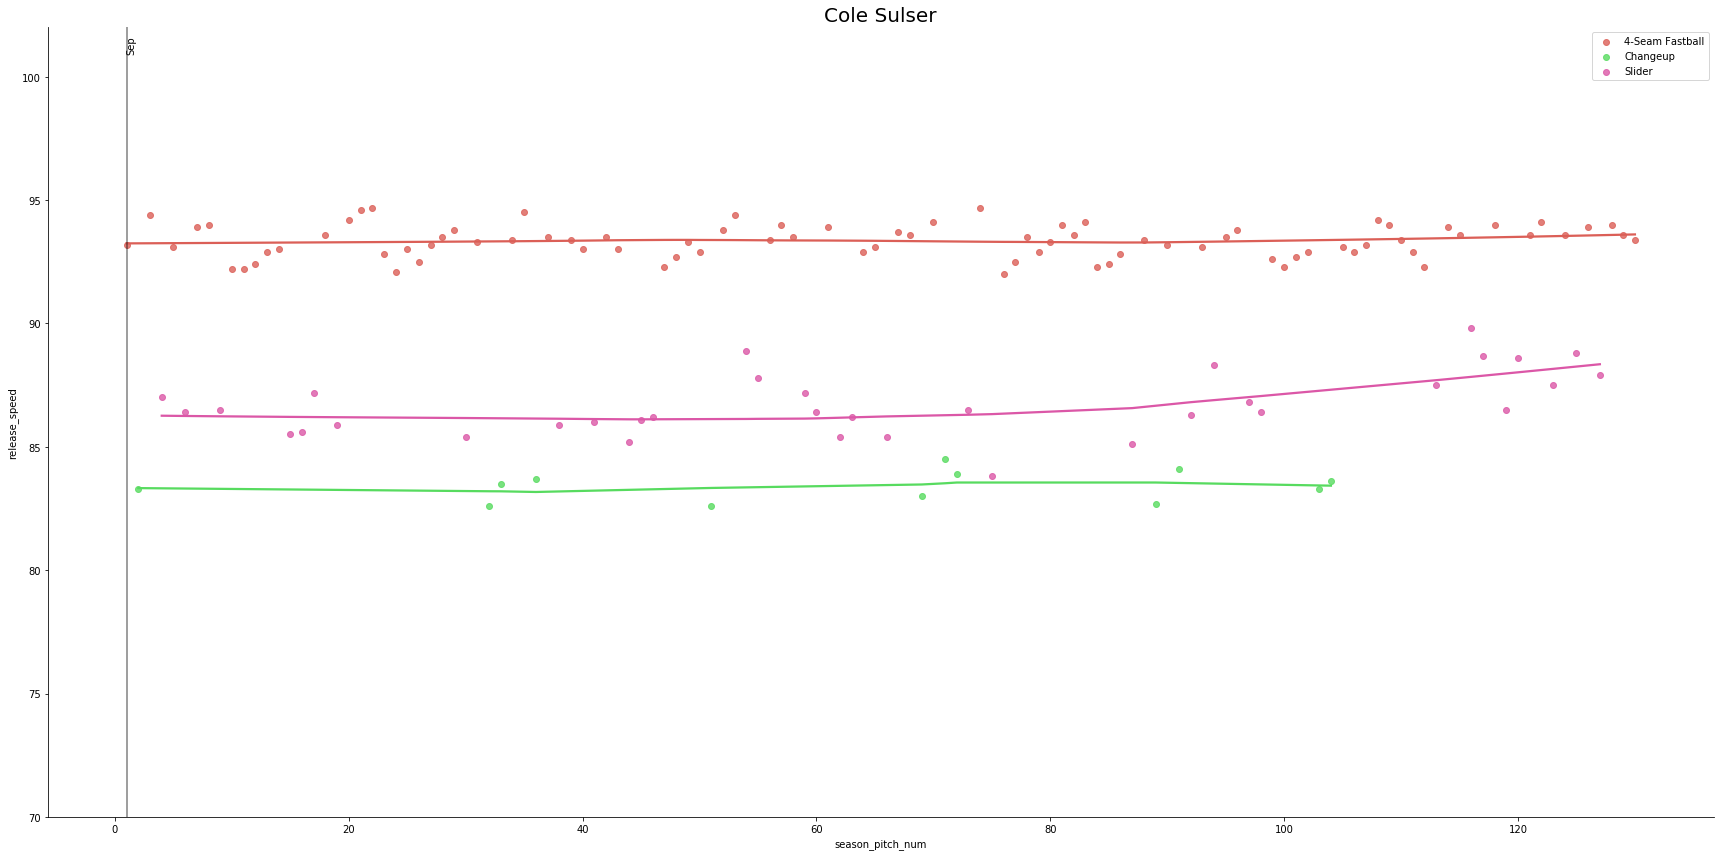

Gathering Player Data


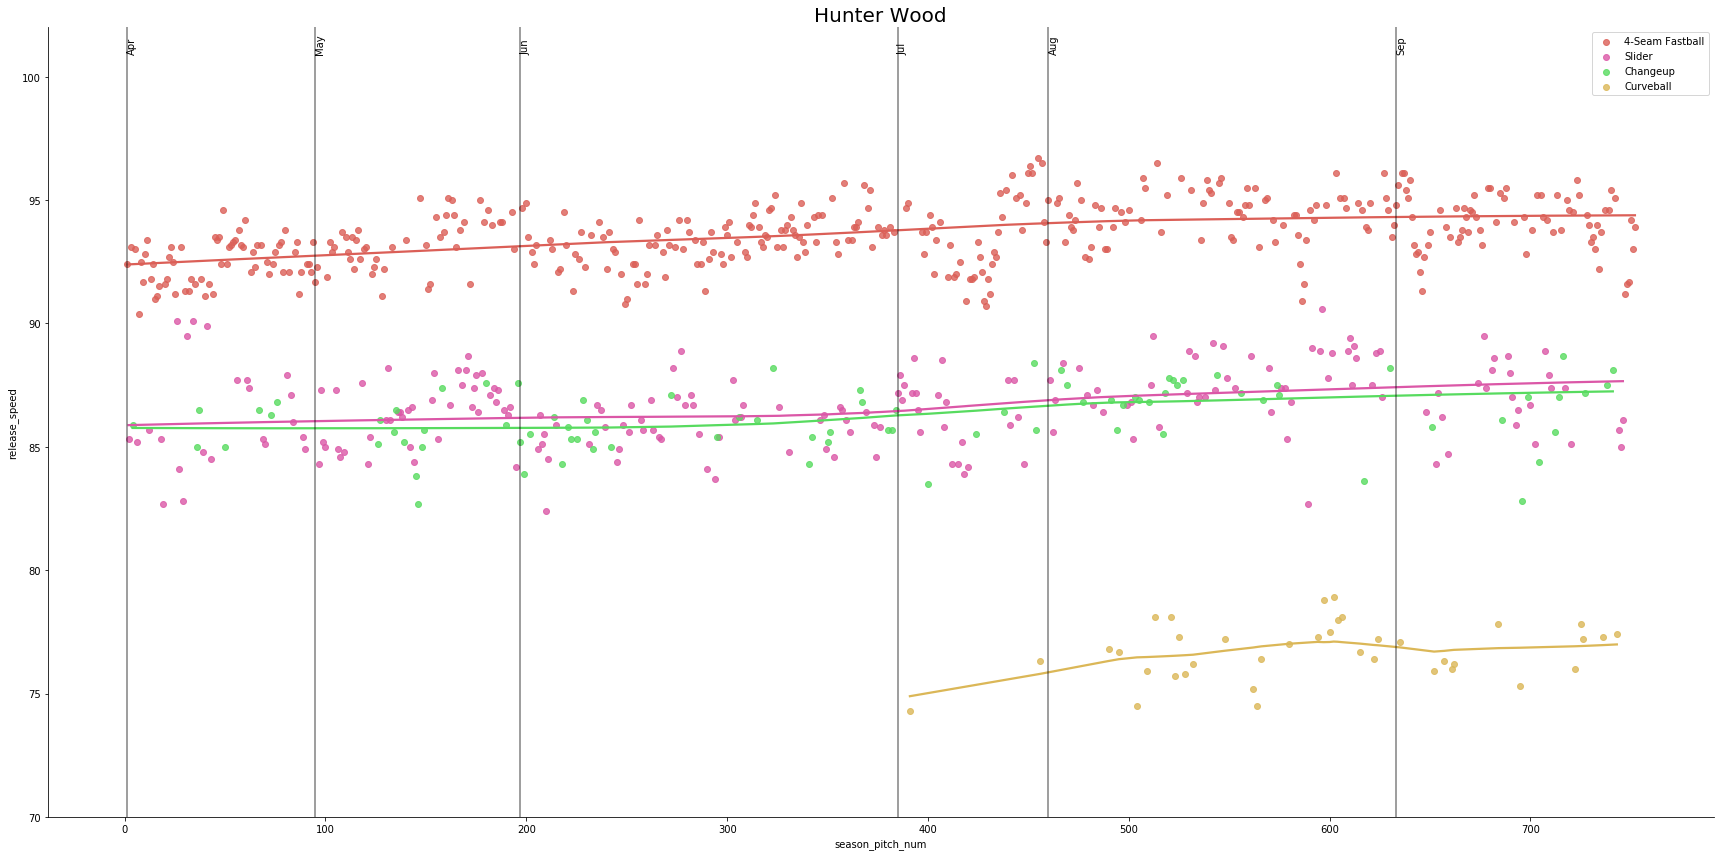

Gathering Player Data


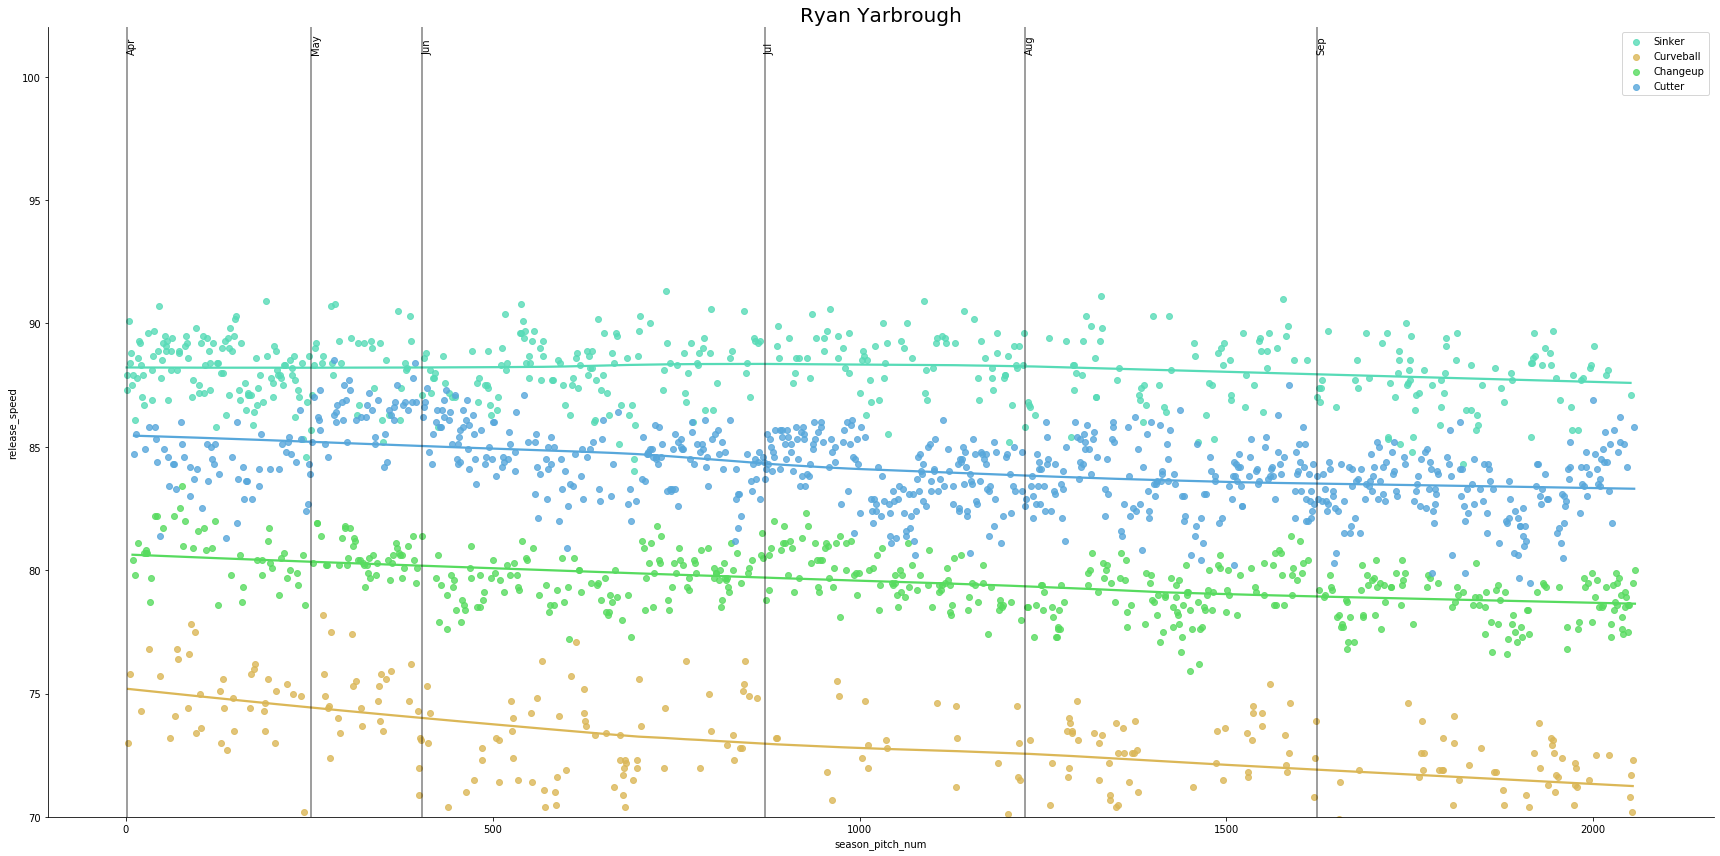

In [6]:
# plot each pitchers graph

for pit in tb.pitcher_id.dropna().astype(int):
    df = get_season_pit_statcast(pit, 2019)
    plot_season_pitch_speeds(df)
